In [1]:
!date

Thu Nov 21 17:23:09 EST 2024


In [2]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-denoise/Code'

In [3]:
%%time
print('running imports')
print('import nibabel as nib'); import nibabel as nib
print('import os'); import os
print('import numpy as np'); import numpy as np
print('import matplotlib.pyplot as plt'); import matplotlib.pyplot as plt
print('import nibabel.processing as nibp'); import nibabel.processing as nibp
print('from scipy import signal'); from scipy import signal
print('from itertools import combinations_with_replacement'); from itertools import combinations_with_replacement
print('from numpy import savetxt'); from numpy import savetxt
print('import nibabel as nib'); import nibabel as nib
print('import math'); import math
print('from numpy import random'); from numpy import random
print('import sklearn.preprocessing  '); import sklearn.preprocessing  
print('import matplotlib.pyplot as plt '); import matplotlib.pyplot as plt 
print('from sklearn.metrics import mean_squared_error'); from sklearn.metrics import mean_squared_error
print('import torch'); import torch
print('from torch import nn'); from torch import nn
print('from torch.nn import functional as F'); from torch.nn import functional as F
print('from torch import Tensor'); from torch import Tensor
print('from typing import List, Callable, Union, Any, TypeVar, Tuple'); from typing import List, Callable, Union, Any, TypeVar, Tuple
print('import torch.optim as optim'); import torch.optim as optim
print('from sklearn.decomposition import PCA'); from sklearn.decomposition import PCA
print('from sklearn import linear_model'); from sklearn import linear_model
print('imports done')
import sys
from IPython import display

running imports
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel.processing as nibp
from scipy import signal
from itertools import combinations_with_replacement
from numpy import savetxt
import nibabel as nib
import math
from numpy import random
import sklearn.preprocessing  
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from typing import List, Callable, Union, Any, TypeVar, Tuple
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn import linear_model
imports done
CPU times: user 965 ms, sys: 210 ms, total: 1.18 s
Wall time: 3.1 s


In [4]:
%%time
print('import ants');import ants
print('from tqdm import tqdm');from tqdm import tqdm
print('import seaborn as sns');import seaborn as sns

import ants


/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


from tqdm import tqdm
import seaborn as sns
CPU times: user 1.01 s, sys: 325 ms, total: 1.34 s
Wall time: 6.07 s


In [5]:
def correlation(x,y):
  x_mean = np.repeat(x.mean(),x.shape,axis=0)
  y_mean = np.repeat(y.mean(),y.shape,axis=0)
  cov = (x-x_mean)*(y-y_mean)
  r = cov.sum()/(x.std()*y.std()*x.shape[0])
  return r

def remove_std0(arr):
    std0 = np.argwhere(np.std(arr, axis=1) == 0.0)
    arr_o = np.delete(arr,std0 ,axis=0) 
    return arr_o

def compute_in(x):
  return (x-3)/2+1

def compute_in_size(x):
  for i in range(4):
    x = compute_in(x)
  return x

def compute_out_size(x):
  return ((((x*2+1)*2+1)*2+1)*2+1)

def compute_padding(x):
  rounding = np.ceil(compute_in_size(x))-compute_in_size(x)
  y = ((((rounding*2)*2)*2)*2)
  pad = bin(int(y)).replace('0b', '')
  if len(pad) < 4:
      for i in range(4-len(pad)):
          pad = '0' + pad
  final_size = compute_in_size(x+y)
  pad_out = bin(int(compute_out_size(final_size)-x)).replace('0b','')
  if len(pad_out) < 4:
      for i in range(4-len(pad_out)):
          pad_out = '0' + pad_out
  return pad,final_size, pad_out

In [6]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    from scipy.spatial.distance import pdist
    from scipy.spatial.distance import squareform
    vec = inVec
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten()))
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose()
                   
    mat = squareform(pdist(vec,metric=metric).transpose())
    if data_scale=='ordinal':
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):
    assert np.ndim(inMat)==2, 'not 2 dim, wtf'
    assert inMat.shape[0]==inMat.shape[1], 'not a square'

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)]
    return triu_vec

In [7]:
def safe_mkdir(path):
    import os
    if not os.path.exists(path):
        os.mkdir(path)

In [8]:
class Scaler():
    def __init__(self,inputs):
        self.data = inputs
        self.mean = np.mean(inputs,axis=1)
        self.std = np.std(inputs, axis=1)
        self.vox, self.time = inputs.shape
    def transform(self,inputs):
        self.mean = np.reshape(self.mean,(self.vox,1))
        self.m_large = np.repeat(self.mean,self.time,axis=1)
        self.std = np.reshape(self.std,(self.vox,1))
        self.s_large = np.repeat(self.std,self.time,axis=1)
        return np.divide(inputs-self.m_large,self.s_large)
    def inverse_transform(self,outputs):
        return np.multiply(outputs,self.s_large)+self.m_large

In [9]:
# class Scaler():
#     def __init__(self,inputs):
#         self.data = inputs
#         self.data_min = self.data.min(axis=1)[:,np.newaxis]
#         self.data_max = self.data.max(axis=1)[:,np.newaxis]
#         self.vox, self.time = inputs.shape
#         #assert self.time==370, f'wrong shape data.shape={self.data.shape}'
    
#     def transform(self,inputs):
#         data_normed = (inputs-self.data_min) / (self.data_max - self.data_min)
#         return data_normed
    
#     def inverse_transform(self,outputs):
#         data_inv = outputs * (self.data_max-self.data_min) + self.data_min
#         return data_inv

In [10]:
class TrainDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.obs = X
    self.noi = Y

  def __len__(self):
    return min(self.obs.shape[0],self.noi.shape[0])

  def __getitem__(self, index):
    observation = self.obs[index]
    noise = self.noi[index]
    s = 2*random.beta(4,4,1)
    noise_aug = s*noise
    return observation, noise_aug
    #return observation, noise

class DenoiseDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X):
    self.obs = X
    
  def __len__(self):
    return self.obs.shape[0]

  def __getitem__(self, index):
    observation = self.obs[index]
    return observation

In [11]:
# Define a shallow classifier (1-neuron network)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(input_dim, 1)  # 1-neuron output layer
    
    def forward(self, x):
        return torch.sigmoid(self.fc(x))  # Apply sigmoid to get a probability between 0 and 1

In [12]:
class cVAE(nn.Module):

    def __init__(self,in_channels: int,in_dim: int, latent_dim: tuple,hidden_dims: List = None, beta : float = 1, gamma : float = 1, delta : float = 1, scale_MSE_GM : float = 1, scale_MSE_CF : float = 1, scale_MSE_FG : float = 1,do_disentangle = True, freq_exp : float = 1, freq_scale : float = 1) -> None:
        super(cVAE, self).__init__()

        self.latent_dim = latent_dim
        self.latent_dim_z = self.latent_dim[0]
        self.latent_dim_s = self.latent_dim[1]
        self.in_channels = in_channels
        self.in_dim = in_dim
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.scale_MSE_GM = scale_MSE_GM
        self.scale_MSE_CF = scale_MSE_CF
        self.do_disentangle = do_disentangle
        self.freq_exp = freq_exp
        self.freq_scale = freq_scale
        self.scale_MSE_FG = scale_MSE_FG

        modules_z = []
        if hidden_dims is None:
            hidden_dims = [64, 128, 256, 256]
        
        self.pad, self.final_size, self.pad_out = compute_padding(self.in_dim)

        # Build Encoder
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_z.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU()
                    )
            )
            in_channels = h_dim

        self.encoder_z = nn.Sequential(*modules_z)
        self.fc_mu_z = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_z)
        self.fc_var_z = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_z)

        modules_s = []
        in_channels = self.in_channels
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_s.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU()
                    )
            )
            in_channels = h_dim

        self.encoder_s = nn.Sequential(*modules_s)
        self.fc_mu_s = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_s)
        self.fc_var_s = nn.Linear(hidden_dims[-1]*int(self.final_size), self.latent_dim_s)


        # Build Decoder
        modules = []

        #self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * int(self.final_size))
        self.decoder_input = nn.Linear(self.latent_dim_s+self.latent_dim_z, hidden_dims[-1] * int(self.final_size))

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose1d(hidden_dims[i],
                                    hidden_dims[i + 1],
                                    kernel_size=3,
                                    stride = 2,
                                    padding=int(self.pad_out[-4+i]),
                                    output_padding=int(self.pad_out[-4+i])),
                    nn.BatchNorm1d(hidden_dims[i + 1]),
                    nn.LeakyReLU()
                    )
            )


        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=int(self.pad_out[-1]),
                                               output_padding=int(self.pad_out[-1])),
                            nn.BatchNorm1d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv1d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1))
           #out_channels

    def encode_z(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_z(input)
  
        result = torch.flatten(result, start_dim=1)


        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_z(result)
        log_var = self.fc_var_z(result)

        return [mu, log_var]

    def encode_s(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_s(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_s(result)
        log_var = self.fc_var_s(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1,256,int(self.final_size))
        #result = result.view(-1,batch_size,int(self.final_size))
        result = self.decoder(result)
        result = self.final_layer(result)

        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward_tg(self, input: Tensor) -> List[Tensor]: # ORIGINAL
        tg_mu_z, tg_log_var_z = self.encode_z(input)
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        output = self.decode(torch.cat((tg_z, tg_s),1))
        return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

    # def forward_tg(self, input: Tensor) -> List[Tensor]:
    #     tg_mu_z, tg_log_var_z = self.encode_z(input)
    #     tg_mu_s, tg_log_var_s = self.encode_s(input)
    #     tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
    #     tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        
    #     #output = self.decode(torch.cat((tg_z, tg_s),1))
    #     output = self.forward_bg(input)[0]+self.forward_fg(input)[0]
    #     return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]


        ### WHAT YUZHU HAD ಠ_ಠ
    # def forward_bg(self, input: Tensor) -> List[Tensor]:
    #     bg_mu_s, bg_log_var_s = self.encode_s(input)
    #     bg_s = self.reparameterize(bg_mu_s, bg_log_var_s)
    #     zeros = torch.zeros_like(bg_s)
    #     output = self.decode(torch.cat((zeros, bg_s),1))
    #     return  [output, input, bg_mu_s, bg_log_var_s]

    # def forward_fg(self, input: Tensor) -> List[Tensor]:
    #     fg_mu_z, fg_log_var_z = self.encode_z(input)
    #     tg_z = self.reparameterize(fg_mu_z, fg_log_var_z)
    #     zeros = torch.zeros_like(tg_z)
    #     output = self.decode(torch.cat((tg_z, zeros),1))
    #     return  [output, input, fg_mu_z, fg_log_var_z]

    def forward_fg(self, input: Tensor) -> List[Tensor]:
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        #zeros = torch.zeros_like(tg_s)
        zeros = torch.zeros(tg_s.shape[0],self.latent_dim_z)
        zeros = zeros.to(device)
        output = self.decode(torch.cat((zeros, tg_s),1))
        return  [output, input, tg_mu_s, tg_log_var_s]

    def forward_bg(self, input: Tensor) -> List[Tensor]:
        bg_mu_z, bg_log_var_z = self.encode_z(input)
        bg_z = self.reparameterize(bg_mu_z, bg_log_var_z)
        #zeros = torch.zeros_like(bg_z)
        zeros = torch.zeros(bg_z.shape[0],self.latent_dim_s)
        zeros = zeros.to(device)
        output = self.decode(torch.cat((bg_z, zeros),1))
        return  [output, input, bg_mu_z, bg_log_var_z]
        

    def loss_function(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        #beta = 0.00001
        #beta = 0.01
        #gamma = 0
        beta = self.beta
        gamma = self.gamma
        delta = self.delta
        #scale_MSE_GM = self.scale_MSE_GM
        #scale_MSE_CF = self.scale_MSE_CF

        #print(beta)
        #print(gamma)

        recons_tg = args[0]
        input_tg = args[1]
        tg_mu_z = args[2]
        tg_log_var_z = args[3]
        tg_mu_s = args[4]
        tg_log_var_s = args[5]
        tg_z = args[6]
        tg_s = args[7]
        recons_bg = args[8]
        input_bg = args[9]
        # bg_mu_s = args[10]
        # bg_log_var_s = args[11]
        bg_mu_z = args[10]
        bg_log_var_z = args[11]

        #kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss_roi = F.mse_loss(recons_tg, input_tg)*self.scale_MSE_GM/batch_size
        recons_loss_roni = F.mse_loss(recons_bg, input_bg)*self.scale_MSE_CF/batch_size
        recons_loss_roni += F.mse_loss(self.forward_bg(recons_tg)[0], recons_bg)*self.scale_MSE_CF/batch_size # reconstructed BG features should look like CF
        recon_fg = self.forward_fg(input_tg)[0]
        recons_loss_fg = F.mse_loss(recon_fg, input_tg)*self.scale_MSE_FG/batch_size
        recons_loss = recons_loss_roi+recons_loss_roni


        #recon_fg = self.forward_fg(input_tg)[0]
        ##recons_loss_fg = F.mse_loss(recon_fg, input_tg)/batch_size
        #recons_loss_fg = F.mse_loss(recon_fg, self.forward_fg(input_bg)[0])/batch_size
        #recons_loss_discourage = recons_loss_fg*-1
        #recons_loss_discourage = recons_loss_discourage*delta


        recons_loss_fg = F.mse_loss(torch.zeros_like(input_bg), self.forward_fg(input_bg)[0])/batch_size
        #recons_loss_fg1 = F.mse_loss(torch.zeros_like(input_bg), self.forward_fg(input_bg)[0])/batch_size
        #recons_loss_discourage = recons_loss_fg*-1
        recons_loss_discourage = recons_loss_fg*delta

        fg_volatility_loss = torch.from_numpy(np.array(0)).to(device)

                          
        do_disentangle=self.do_disentangle
        if do_disentangle==True:
            # qz_s = torch.cat([tg_z, tg_s], dim=1)
            # mu = torch.cat([tg_mu_z, tg_mu_s], dim=1)
            # log_var = torch.cat([tg_log_var_z, tg_log_var_s], dim=1)

            # # Compute log q(z, s)
            # log_qz_s = self._compute_log_density_gaussian(qz_s, mu, log_var)

            # # Compute log q(z) + log q(s)
            # # Shuffle z and s to break dependencies
            # z_perm = tg_z[torch.randperm(tg_z.size(0))]
            # s_perm = tg_s[torch.randperm(tg_s.size(0))]
            # qz_s_perm = torch.cat([z_perm, s_perm], dim=1)
            # log_qz_s_perm = self._compute_log_density_gaussian(qz_s_perm, mu, log_var)

            # # Total Correlation Loss
            # total_contrastive_loss = (log_qz_s - log_qz_s_perm).mean()

            pdist = torch.cdist
            cmat1 = pdist(tg_z, tg_z)
            cmat1=cmat1[torch.triu(torch.ones_like(cmat1), diagonal=1).bool()]
            
            cmat2 = pdist(tg_s, tg_s)
            cmat2 = cmat2[torch.triu(torch.ones_like(cmat2), diagonal=1).bool()]
            
            total_contrastive_loss = torch.abs(torch.corrcoef(torch.stack([cmat1,cmat2]))[0,1])
        else:
            total_contrastive_loss = torch.from_numpy(np.array(0)).to(device)
                          
        # if do_disentangle==True:
        #     z1 = tg_z[:int(batch_size/2), :]  # First half of z
        #     z2 = tg_z[int(batch_size/2):, :]  # Second half of z
        #     s1 = tg_s[:int(batch_size/2), :]  # First half of s
        #     s2 = tg_s[int(batch_size/2):, :]  # Second half of s
    
        #     # print(f'tg_z.shape {tg_z.shape}')
        #     # print(f'tg_s.shape {tg_s.shape}')
        #     # print(f'z1.shape {z1.shape}')
        #     # print(f'z2.shape {z2.shape}')
        #     # print(f's1.shape {s1.shape}')
        #     # print(f's2.shape {s2.shape}')
                              
        #     # # Construct "positive" and "negative" samples for contrastive learning
        #     # q = torch.cat((s1, z1), dim=1)  # Positive pairs (s1, z1)
        #     # q_bar = torch.cat((s1, z2), dim=1)  # Negative pairs (s1, z2)
    
        #     # Construct "positive" pairs
        #     q1 = torch.cat((s1, z1), dim=1)  # Positive pairs from first half (s1, z1)
        #     q2 = torch.cat((s2, z2), dim=1)  # Positive pairs from second half (s2, z2)
        #     q = torch.cat((q1, q2), dim=0)   # Combine the two sets of positive pairs
    
        #     # Construct "negative" pairs by misaligning the latent variables
        #     q_bar1 = torch.cat((s1, z2), dim=1)  # Negative pairs from mismatched (s1, z2)
        #     q_bar2 = torch.cat((s2, z1), dim=1)  # Negative pairs from mismatched (s2, z1)
        #     q_bar = torch.cat((q_bar1, q_bar2), dim=0)  # Combine the two sets of negative pairs


        #     # # Compute the scores
        #     q_score = discriminator(q)  # Positive pair scores
        #     q_bar_score = discriminator(q_bar)  # Negative pair scores

        #     # If q_score or q_bar_score is zero, then log will return NaN, shift values to overcome this
        #     q_score = (q_score+.1)*.85
        #     q_bar_score = (q_bar_score+.1)*.85
    
        #     # Implement the density-ratio trick
        #     # tc_loss = log(P(positive) / P(negative))
        #     tc_loss = torch.mean(torch.log(q_score / (1 - q_score)))  # Density ratio loss
    
        #     # Discriminator loss: encourage correct classification of positive and negative pairs
        #     discriminator_loss = -torch.mean(torch.log(q_score) + torch.log(1 - q_bar_score))
    
        #     # Total loss would combine these losses (tc_loss + discriminator_loss can be weighted)        
        #     total_contrastive_loss = tc_loss + discriminator_loss
        #     #total_contrastive_loss = torch.sum(tc_loss + discriminator_loss)
        #     #total_contrastive_loss = tc_loss
        # else:
        #     total_contrastive_loss = torch.from_numpy(np.array(0)).to(device)



        # kld_loss = 1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp()
        # kld_loss += 1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp()
        # kld_loss += 1 + bg_log_var_z - bg_mu_z ** 2 - bg_log_var_z.exp()
        # kld_loss = torch.mean(-0.5 * torch.sum(kld_loss, dim = 1), dim = 0)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp(), dim = 1), dim = 0)
        kld_loss += torch.mean(-0.5 * torch.sum(1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp(), dim = 1), dim = 0)
        kld_loss += torch.mean(-0.5 * torch.sum(1 + bg_log_var_z - bg_mu_z ** 2 - bg_log_var_z.exp(), dim = 1), dim = 0)
        kld_loss = kld_loss/3
        

                          

        if do_disentangle==True:
            loss = torch.sum(recons_loss + beta*kld_loss + gamma*total_contrastive_loss + recons_loss_roi + recons_loss_roni + recons_loss_discourage + fg_volatility_loss + recons_loss_fg)
            return {
                'loss': loss, 
                'Reconstruction_Loss':recons_loss.detach(), 
                'KLD': kld_loss.detach()*beta, 
                'total_contrastive_loss' : total_contrastive_loss*gamma, 
                'recons_loss_roni' : recons_loss_roni.detach(), 
                'recons_loss_roi' : recons_loss_roi.detach(), 
                'recons_loss_discourage' : recons_loss_discourage.detach(), 
                'fg_volatility_loss': fg_volatility_loss.detach(), 
                'recons_loss_fg' : recons_loss_fg.detach()
                }
            
        else:
            loss = torch.sum(recons_loss + beta*kld_loss + gamma*total_contrastive_loss)
            return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD': kld_loss.detach()*beta, 'total_contrastive_loss' : total_contrastive_loss.detach()*gamma, 'recons_loss_roni' : recons_loss_roni.detach(), 'recons_loss_roi' : recons_loss_roi.detach(), 'recons_loss_discourage' : recons_loss_discourage}

    # def sample(self,
    #            num_samples:int,
    #            current_device: int) -> Tensor:
    #     """
    #     Samples from the latent space and return the corresponding
    #     image space map.
    #     :param num_samples: (Int) Number of samples
    #     :param current_device: (Int) Device to run the model
    #     :return: (Tensor)
    #     """
    #     z = torch.randn(num_samples,
    #                     self.latent_dim)

    #     z = z.to(current_device)

    #     samples = self.decode(z)
    #     return samples

    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward_fg(x)[0]

    def _compute_log_density_gaussian(self, z, mu, log_var):
            """
            Computes the log density of a Gaussian for each sample in the batch.
            """
            normalization = -0.5 * (math.log(2 * math.pi) + log_var)
            log_prob = normalization - 0.5 * ((z - mu) ** 2 / log_var.exp())
            return log_prob.sum(dim=1)

In [13]:
def get_corr_w_reg():
    ffa_batch = ffa_list[0:batch_size,:]
    ffa_batch = torch.tensor(ffa_batch[:,np.newaxis,:]).to(device)
    
    ffa_tg = model.forward_tg(ffa_batch)
    ffa_tg = ffa_tg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_fg = model.forward_fg(ffa_batch)
    ffa_fg = ffa_fg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_bg = model.forward_bg(ffa_batch)
    ffa_bg = ffa_bg[0].detach().cpu().numpy()[:,0,:]
    
    c_ffa_bold_facereg = np.corrcoef(ffa_list[:,:].mean(axis=0),face_reg)[0,1]
    c_ffa_bold_placereg = np.corrcoef(ffa_list[:,:].mean(axis=0),place_reg)[0,1]
    c_ffa_bold_diff = c_ffa_bold_facereg-c_ffa_bold_placereg
    
    c_tg_bold_facereg = np.corrcoef(ffa_tg[:,:].mean(axis=0),face_reg)[0,1]
    c_tg_bold_placereg = np.corrcoef(ffa_tg[:,:].mean(axis=0),place_reg)[0,1]
    c_tg_bold_diff = c_tg_bold_facereg-c_tg_bold_placereg
    
    c_fg_bold_facereg = np.corrcoef(ffa_fg[:,:].mean(axis=0),face_reg)[0,1]
    c_fg_bold_placereg = np.corrcoef(ffa_fg[:,:].mean(axis=0),place_reg)[0,1]
    c_fg_bold_diff = c_fg_bold_facereg-c_fg_bold_placereg
    
    c_bg_bold_facereg = np.corrcoef(ffa_bg[:,:].mean(axis=0),face_reg)[0,1]
    c_bg_bold_placereg = np.corrcoef(ffa_bg[:,:].mean(axis=0),place_reg)[0,1]
    c_bg_bold_diff = c_bg_bold_facereg-c_bg_bold_placereg
    
    return [c_ffa_bold_facereg,
    c_ffa_bold_placereg,
    c_ffa_bold_diff,
    c_tg_bold_facereg,
    c_tg_bold_placereg,
    c_tg_bold_diff,
    c_fg_bold_facereg,
    c_fg_bold_placereg,
    c_fg_bold_diff,
    c_bg_bold_facereg,
    c_bg_bold_placereg,
    c_bg_bold_diff]

In [14]:
indir = '../Data/020-fmriprepped/'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
n_orig = len(subs_orig)
epi_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii')
#cf_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_CF.nii')
#gm_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_GM.nii')
cf_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_CF-strict.nii')
gm_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_GM-strict.nii')
brain_mask = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')

subs = [sub for sub in subs_orig if all(( 
    os.path.exists(epi_fn.format(sub=sub,r=1)),
    os.path.exists(epi_fn.format(sub=sub,r=2)),
    os.path.exists(cf_fn.format(sub=sub)),
    os.path.exists(gm_fn.format(sub=sub)),
    os.path.exists(brain_mask.format(sub=sub)),
    ))]

subs.sort()
print(f'{len(subs)}/{len(subs_orig)}')

34/34


In [15]:
#Clear out old files
clear_old_files = False
if clear_old_files==True:
    for sub in tqdm(subs):
        for r in [1,2]:
            if os.path.exists(epi_fn.format(sub=sub,r=r).replace('preproc','DEEPCOR-TG')):
                os.remove(epi_fn.format(sub=sub,r=r).replace('preproc','DEEPCOR-TG'))
            
            if os.path.exists(epi_fn.format(sub=sub,r=r).replace('preproc','DEEPCOR-BG')):
                os.remove(epi_fn.format(sub=sub,r=r).replace('preproc','DEEPCOR-BG'))
            
            if os.path.exists(epi_fn.format(sub=sub,r=r).replace('preproc','DEEPCOR-FG')):
                os.remove(epi_fn.format(sub=sub,r=r).replace('preproc','DEEPCOR-FG'))
            
            if os.path.exists(epi_fn.format(sub=sub,r=r).replace('preproc','DEEPCOR-twin')):
                os.remove(epi_fn.format(sub=sub,r=r).replace('preproc','DEEPCOR-twin'))

In [16]:
s = 5
r = 2
rep = 1
analysis_name = 'test'

In [17]:
s = int(s)
r = int(r)

sub = subs[s]
#sub = 'sub-NDARINVRF70B79M'
print(sub)

epi = ants.image_read(epi_fn.format(sub=sub,r=r))
#epi = ants.image_read(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','COMPCORR_bold.nii'))
gm = ants.image_read(gm_fn.format(sub=sub))
brain = ants.image_read(brain_mask.format(sub=sub))
cf = ants.image_read(cf_fn.format(sub=sub))

nt = epi.shape[-1] # Number of timepoints
ndummy = 8 # how many dummies to discard

epi_flat = epi.numpy().reshape(-1,nt).transpose() # (370, 1082035)
epi_flat[0:ndummy,:] = epi_flat[ndummy+1::,:].mean(axis=0) # What to do with dummy scans, set to mean
epi_flat = epi_flat.transpose()
gm_flat = gm.numpy().flatten().astype(int) # (1082035,)
cf_flat = cf.numpy().flatten().astype(int) # (1082035,)
assert max(np.unique(cf_flat+gm_flat))!=2, 'overlap' # Check for overlap again

sub-NDARINV8RN0AJRP


In [18]:
(cf.numpy()==1).sum(),(gm.numpy()==1).sum()

(4028, 36682)

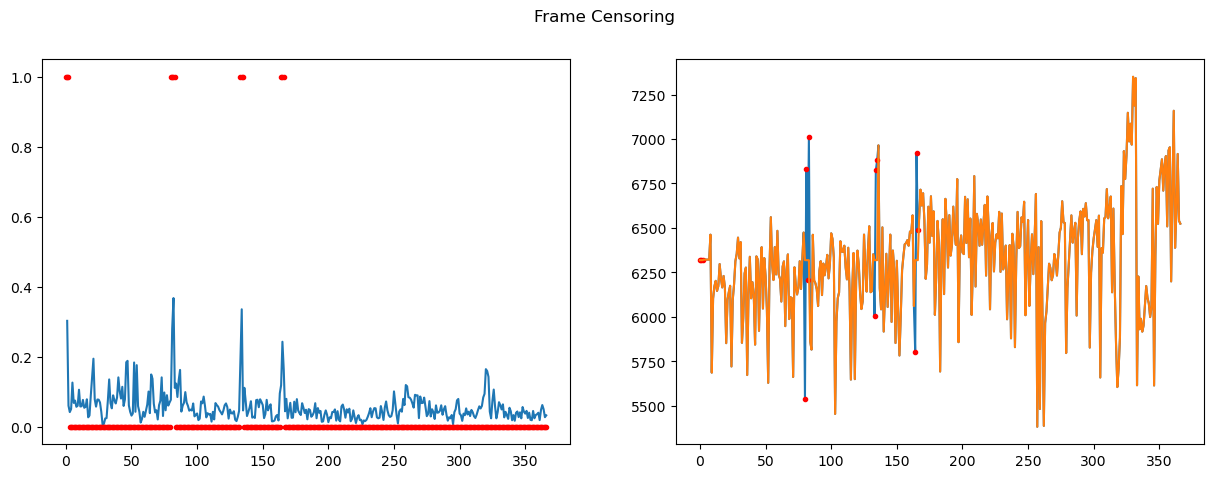

In [19]:
do_censor_frames=True
if do_censor_frames:
    import pandas as pd
    mot_fn = f'../Data/020-fmriprepped/{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_desc-confounds_timeseries.tsv'
    mot = pd.read_csv(mot_fn,delimiter='\t')
    mot_outliers = mot['framewise_displacement'].values>.2
    mot_outliers = np.vstack((mot_outliers,np.hstack((False,mot_outliers[0:-1])),np.hstack((mot_outliers[1::],False)))).sum(axis=0)>0
    outlier_idx = np.nonzero(mot_outliers)[0]
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(mot['framewise_displacement'].values)
    plt.plot(mot_outliers,'r.')
    
    plt.subplot(1,2,2)
    plot_vec = epi_flat[gm_flat==1,:][5000,:]
    outlier_idx = np.nonzero(mot_outliers)[0]
    plt.plot(plot_vec)
    plt.plot(outlier_idx,plot_vec[outlier_idx],'r.')
    
    plot_vec[mot_outliers] = plot_vec[~mot_outliers].mean()
    plt.plot(plot_vec)
    
    epi_flat[:,mot_outliers] = epi_flat[:,~mot_outliers].mean(axis=1)[:,np.newaxis]
    plt.suptitle('Frame Censoring')

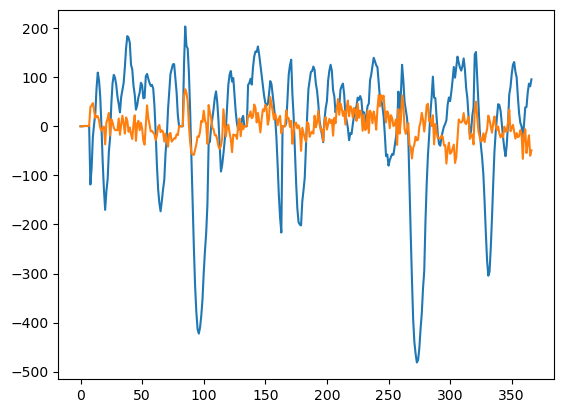

In [20]:
do_compcorr=True
if do_compcorr==True:
    from sklearn.decomposition import PCA
    from sklearn import linear_model
    
    cf_for_compcorr = ants.image_read(os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_CF.nii').format(sub=sub,r=r))
    
    cf_pcs = PCA(n_components=5).fit_transform(epi_flat[cf_for_compcorr.numpy().flatten()==1,:].transpose())
    
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(cf_pcs,epi_flat[gm_flat==1,:].transpose());
    
    predicted = lin_reg.predict(cf_pcs)
    residuals = epi_flat[gm_flat==1,:].transpose()-predicted
    plt.plot(epi_flat[gm_flat==1,:].mean(axis=0)-epi_flat[gm_flat==1,:].mean(axis=0).mean())
    epi_flat[gm_flat==1,:]=residuals.transpose()
    plt.plot(epi_flat[gm_flat==1,:].mean(axis=0)-epi_flat[gm_flat==1,:].mean(axis=0).mean())

In [21]:
#residuals.shape

In [22]:
print(epi_flat.shape)
print(sum(gm_flat==1))
print(sum(cf_flat==1))

(1082035, 367)
36682
4028


In [23]:
func_gm = epi_flat[gm_flat==1,:]
func_cf = epi_flat[cf_flat==1,:]

In [24]:
brain_flat = brain.numpy().flatten()>.5

In [25]:
brain_gm = epi_flat[brain_flat,:]
brain_gm = remove_std0(brain_gm)
brain_gm.shape

(125201, 367)

/data/aglinska/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning:

The nilearn.glm module is experimental. It may change in any future release of Nilearn.



Text(0.5, 1.0, 'ffa activity + regs\nffa corr w/ face: 0.43\nffa corr w/ place: -0.05')

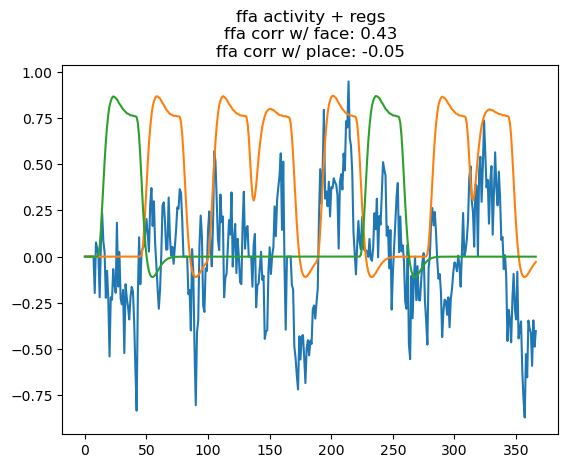

In [26]:
from nilearn.glm.first_level import make_first_level_design_matrix
import pandas as pd
events_fn = f'../Data/010-Data_bids2/{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv'
events = pd.read_csv(events_fn,delimiter='\t')

t_r = 0.8  # repetition time is 1 second
n_scans = epi_flat.shape[1]  # the acquisition comprises 128 scans
frame_times = (np.arange(n_scans) * t_r)

X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

face_reg = X1[['0_back_neutface','2_back_neutface','0_back_negface','2_back_negface','0_back_posface','2_back_posface',]].values.sum(axis=1)
place_reg = X1[['0_back_place','2_back_place']].values.sum(axis=1)

ffa_im = ants.image_read('../Misc/ffa_mask_resampled.nii')
func_ffa = func_gm[ffa_im.numpy().flatten()[gm_flat==1]==1,:]
ffa_scaler = Scaler(func_ffa)
ffa_list = ffa_scaler.transform(func_ffa)

plt.plot(ffa_list[:,:].mean(axis=0))
plt.plot(face_reg)
plt.plot(place_reg)
plt.title('ffa activity + regs\n'+'ffa corr w/ face: {:.2f}\nffa corr w/ place: {:.2f}'.format(np.corrcoef(ffa_list[:,:].mean(axis=0),face_reg)[0,1],np.corrcoef(ffa_list[:,:].mean(axis=0),place_reg)[0,1]))

In [27]:
(np.corrcoef(func_ffa.mean(axis=0),face_reg)[0,1],
np.corrcoef(func_ffa.mean(axis=0),place_reg)[0,1],)

(0.44248426575179095, -0.04122892025332707)

In [28]:
(np.array([np.corrcoef(func_ffa[v,:],face_reg)[0,1] for v in range(func_ffa.shape[0])]).mean(),
np.array([np.corrcoef(func_ffa[v,:],place_reg)[0,1] for v in range(func_ffa.shape[0])]).mean(),)

(0.1324795250146508, -0.015354178996243986)

In [29]:
assert os.path.exists( epi_fn.replace('preproc','COMPCORR').format(sub=sub,r=r) )
compcorr_ffa = ants.image_read(epi_fn.replace('preproc','COMPCORR').format(sub=sub,r=r))
compcorr_ffa = compcorr_ffa.numpy()[ffa_im.numpy()==1]

(np.corrcoef(compcorr_ffa.mean(axis=0),face_reg)[0,1],
np.corrcoef(compcorr_ffa.mean(axis=0),place_reg)[0,1],)

(0.5126620889365159, -0.051747486024836836)

In [30]:
(np.nanmean([np.corrcoef(compcorr_ffa[v,:],face_reg)[0,1] for v in range(compcorr_ffa.shape[0])]),
np.nanmean([np.corrcoef(compcorr_ffa[v,:],place_reg)[0,1] for v in range(compcorr_ffa.shape[0])]),)

/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning:

invalid value encountered in true_divide

/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning:

invalid value encountered in true_divide



(0.15601808043612292, -0.018999092853586187)

In [31]:
# func_gm = func_gm[0::20,:]
# func_cf = func_cf[0::10,:]

In [32]:
def generate_correlated_fmri_noise(length, num_voxels, 
                                   phys_noise_level=0.1, 
                                   motion_noise_level=0.1, 
                                   drift_noise_level=0.05, 
                                   low_freq_noise_level=0.02, 
                                   correlation=0.5, 
                                   seed=None):
    """
    Generates correlated fMRI noise for multiple voxels.
    
    Parameters:
    length (int): Length of the time series (e.g., number of time points in the fMRI scan).
    num_voxels (int): Number of voxels (i.e., how many correlated noise vectors you want).
    phys_noise_level (float): Magnitude of physiological noise (e.g., respiratory and cardiac noise).
    motion_noise_level (float): Magnitude of motion-related noise.
    drift_noise_level (float): Magnitude of scanner drift noise (low-frequency drift).
    low_freq_noise_level (float): Magnitude of general low-frequency noise.
    correlation (float): Desired correlation between noise vectors (between 0 and 1).
    seed (int, optional): Random seed for reproducibility.

    Returns:
    np.ndarray: A matrix of shape (num_voxels, length) with correlated noise for each voxel.
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    # Generate uncorrelated noise for each voxel
    noise_matrix = np.zeros((num_voxels, length))

    for i in tqdm(range(num_voxels)):
        # Generate physiological noise
        phys_noise = phys_noise_level * np.sin(np.linspace(0, 10 * np.pi, length)) * np.random.randn(length)
        
        # Generate motion-related noise (random spikes in signal)
        motion_noise = np.zeros(length)
        for _ in range(int(motion_noise_level * 10)):  # Random number of motion artifacts
            idx = np.random.randint(0, length-5)
            motion_noise[idx:idx+5] = np.random.randn(5) * motion_noise_level  # Add small burst of motion artifact
        
        # Generate low-frequency drift (scanner drift or baseline shift)
        drift_noise = drift_noise_level * np.polyval(np.random.randn(2), np.linspace(-1, 1, length))
        
        # General low-frequency noise (slow oscillations)
        low_freq_noise = low_freq_noise_level * np.sin(np.linspace(0, 2 * np.pi, length)) * np.random.randn(length)
        
        # Combine noise components for each voxel
        noise_matrix[i, :] = phys_noise + motion_noise + drift_noise + low_freq_noise
    
    # Create a correlation matrix
    corr_matrix = np.full((num_voxels, num_voxels), correlation) + np.eye(num_voxels) * (1 - correlation)
    
    # Cholesky decomposition to apply the correlation
    cholesky_decomp = np.linalg.cholesky(corr_matrix)
    
    # Apply the correlation structure to the noise matrix
    correlated_noise = np.dot(cholesky_decomp, noise_matrix)
    
    return correlated_noise





from scipy import signal
from scipy.stats import gamma

def spm_hrf(tr, length=32, peak_delay=6, undershoot_delay=16, peak_disp=1, undershoot_disp=1, ratio=6, scale=1.0):
    """
    Generates a hemodynamic response function (HRF) similar to the SPM canonical HRF.

    Parameters:
    tr (float): Repetition time (TR) of the fMRI scan (in seconds).
    length (float): Length of the HRF (in seconds).
    peak_delay (float): Time to the peak of the HRF (in seconds).
    undershoot_delay (float): Time to the undershoot of the HRF (in seconds).
    peak_disp (float): Dispersion of the peak.
    undershoot_disp (float): Dispersion of the undershoot.
    ratio (float): Ratio of the peak to the undershoot.
    scale (float): Scaling factor for the HRF.

    Returns:
    np.ndarray: The HRF vector sampled at intervals of the TR.
    """
    # Time points at which to evaluate the HRF
    t = np.arange(0, length, tr)
    
    # Gamma function for the peak and undershoot
    peak = gamma.pdf(t, peak_delay / peak_disp, scale=peak_disp)
    undershoot = gamma.pdf(t, undershoot_delay / undershoot_disp, scale=undershoot_disp)
    
    # HRF is the sum of the peak and undershoot components
    hrf = peak - undershoot / ratio
    
    # Normalize and scale the HRF
    hrf /= np.max(hrf)
    hrf *= scale
    
    return hrf

def simulate_voxel_response(boxcar, tr, hrf=None):
    """
    Simulates a voxel response to a task by convolving a boxcar task design with an HRF.
    
    Parameters:
    boxcar (np.ndarray): A binary vector (1=task on, 0=task off) representing the task design.
    tr (float): Repetition time (TR) of the fMRI scan (in seconds).
    hrf (np.ndarray, optional): A custom HRF. If None, a default SPM-like HRF will be used.
    
    Returns:
    np.ndarray: The simulated voxel response (BOLD signal).
    """
    # If no HRF is provided, use a default SPM-like HRF
    if hrf is None:
        hrf = spm_hrf(tr)
    
    # Convolve the boxcar with the HRF to generate the voxel response
    response = signal.convolve(boxcar, hrf)[:len(boxcar)]
    
    return response



def get_gt():
    # Example usage:
    tr = .8  # Repetition time of 2 seconds
    duration = 370  # Number of time points
    boxcar = np.zeros(duration)
    #ons = np.random.randint(low=0,high=300)
    ons = np.random.choice([50,150,250])
    boxcar[ons:ons+100] = 1  # Task "on" from time points 10 to 30
    #boxcar[200:250] = 1  # Task "on" again from time points 50 to 70
    
    # Simulate voxel response
    voxel_response = simulate_voxel_response(boxcar, tr)
    return voxel_response


In [33]:
#Example usage:
do_synth_data = False
if do_synth_data==True:
    num_voxels = 12_500
    noise_matrix = generate_correlated_fmri_noise(length=370, num_voxels=num_voxels, 
                                                  phys_noise_level=0.2, motion_noise_level=0.1, 
                                                  drift_noise_level=0.05, correlation=0.5, seed=42)
    
    
    #gound_truth = np.array([get_gt()*.01 for _ in range(num_voxels)])
    gound_truth = np.array([get_gt()*.1 for _ in range(num_voxels)])
    
    func_cf = noise_matrix
    func_gm = noise_matrix+gound_truth
    
    func_cf = func_cf*240
    func_gm = func_gm*240
    brain_gm = func_gm

    # func_cf[0:2_500] = func_gm[10_000:12_500,:]
    # func_gm = func_gm[0:10_000,:]
    # func_cf = func_cf[0:10_000,:]
    # gound_truth = gound_truth[0:10_000]
    brain_gm = func_gm 

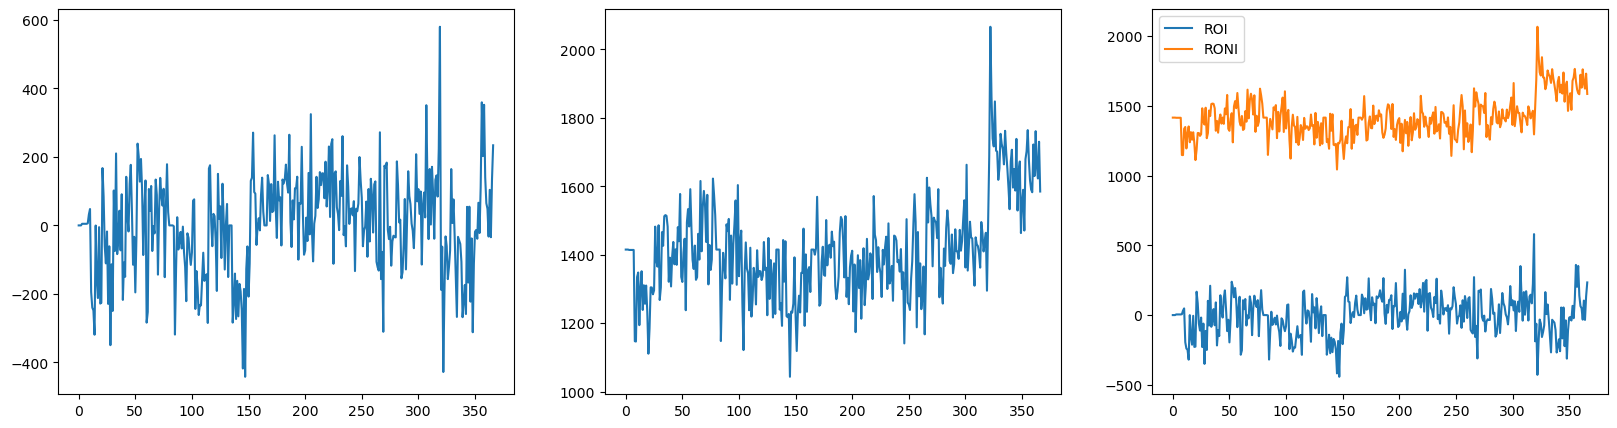

In [34]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1);plt.plot(func_gm[0,:])
plt.subplot(1,3,2);plt.plot(func_cf[0,:])
plt.subplot(1,3,3);plt.plot(func_gm[0,:]);plt.plot(func_cf[0,:]);plt.legend(['ROI','RONI'])

In [35]:
print(func_gm.shape)
print(func_cf.shape)

(36682, 367)
(4028, 367)


In [36]:
#Normalization of Data
func_gm = remove_std0(func_gm)
func_cf = remove_std0(func_cf)
print(func_gm.shape)
print(func_cf.shape)

(36656, 367)
(4028, 367)


In [37]:
obs_scale = Scaler(func_gm)
obs_list = obs_scale.transform(func_gm)
print(obs_list.shape)
noi_scale = Scaler(func_cf)
noi_list = noi_scale.transform(func_cf)
print(noi_list.shape)

(36656, 367)
(4028, 367)


(array([3.00000e+00, 1.74000e+02, 5.85600e+03, 1.27807e+05, 7.50373e+05,
        5.30335e+05, 6.13850e+04, 2.22400e+03, 1.05000e+02, 1.40000e+01]),
 array([-7.3952513 , -5.8768125 , -4.358373  , -2.8399343 , -1.3214954 ,
         0.19694352,  1.7153825 ,  3.2338214 ,  4.75226   ,  6.2706995 ,
         7.7891383 ], dtype=float32),
 <BarContainer object of 10 artists>)

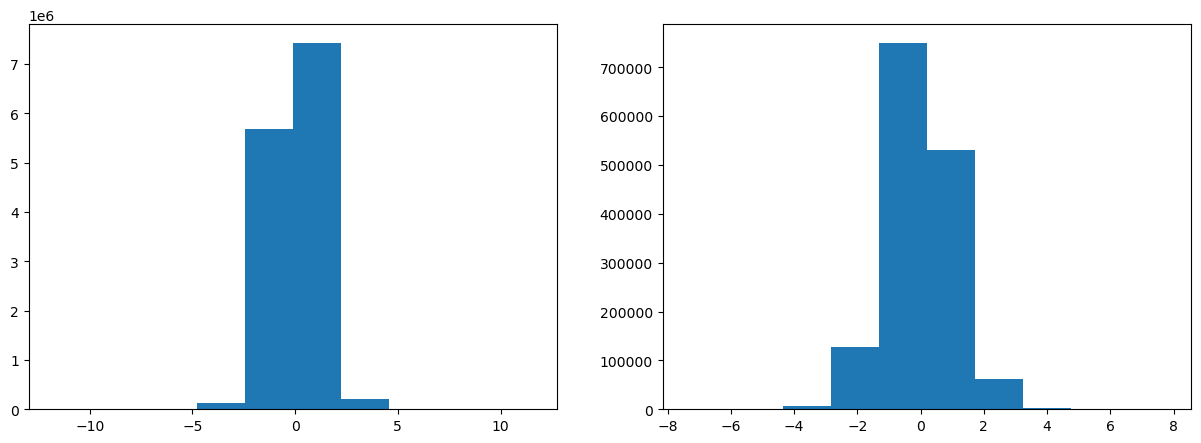

In [38]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(obs_list.flatten())

plt.subplot(1,2,2)
plt.hist(noi_list.flatten())

In [39]:
def norm(mat):
    return (mat - mat.min()) / ( mat.max()-mat.min() )

In [40]:
min_obs_list = obs_list.min()
max_obs_list = obs_list.max()

min_noi_list = noi_list.min()
max_noi_list = noi_list.max()

In [41]:
do_norm = False
if do_norm==True:
    obs_list = norm(obs_list)
    noi_list = norm(noi_list)

In [42]:
def plot_r_w_reg():
    corr_w_reg = np.array(track['corr_w_reg'])
    c_ffa_bold_facereg = corr_w_reg[:,0]
    c_ffa_bold_placereg = corr_w_reg[:,1]
    c_ffa_bold_diff = corr_w_reg[:,2]
    c_tg_bold_facereg = corr_w_reg[:,3]
    c_tg_bold_placereg = corr_w_reg[:,4]
    c_tg_bold_diff = corr_w_reg[:,5]
    c_fg_bold_facereg = corr_w_reg[:,6]
    c_fg_bold_placereg = corr_w_reg[:,7]
    c_fg_bold_diff = corr_w_reg[:,8]
    c_bg_bold_facereg = corr_w_reg[:,9]
    c_bg_bold_placereg = corr_w_reg[:,10]
    c_bg_bold_diff = corr_w_reg[:,11]
    
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(c_ffa_bold_diff)
    plt.plot(c_tg_bold_diff)
    plt.plot(c_fg_bold_diff)
    plt.plot(c_bg_bold_diff)
    plt.legend(['ffa','tg','fg','bg'])
    plt.title(f'Diff {c_fg_bold_diff[-1]:.2f}')
    
    plt.subplot(1,3,2)
    plt.plot(c_ffa_bold_facereg)
    plt.plot(c_tg_bold_facereg)
    plt.plot(c_fg_bold_facereg)
    plt.plot(c_bg_bold_facereg)
    plt.legend(['ffa','tg','fg','bg'])
    plt.title('Face Reg')
    
    plt.subplot(1,3,3)
    plt.plot(c_ffa_bold_placereg)
    plt.plot(c_tg_bold_placereg)
    plt.plot(c_fg_bold_placereg)
    plt.plot(c_bg_bold_placereg)
    plt.legend(['ffa','tg','fg','bg'])
    plt.title('Place Reg')

In [43]:
def show_voxel_recon():
    plt.figure(figsize=(15,5))
    plt.plot( inputs_gm.detach().cpu().numpy()[:,0,:][0,:] )
    plt.plot( outputs_gm_tg.detach().cpu().numpy()[:,0,:][0,:] )
    plt.plot( outputs_gm_fg.detach().cpu().numpy()[:,0,:][0,:] )
    plt.plot( outputs_gm_bg.detach().cpu().numpy()[:,0,:][0,:] )
    plt.legend(['inputs_gm','outputs_gm_tg','outputs_gm_fg','outputs_gm_bg'])
    plt.title('GM')
    
    
    plt.figure(figsize=(15,5))
    plt.plot( inputs_cf.detach().cpu().numpy()[:,0,:][0,:] )
    plt.plot( outputs_cf_tg.detach().cpu().numpy()[:,0,:][0,:] )
    plt.plot( outputs_cf_fg.detach().cpu().numpy()[:,0,:][0,:] )
    plt.plot( outputs_cf_bg.detach().cpu().numpy()[:,0,:][0,:] )
    plt.legend(['inputs_cf','outputs_cf_tg','outputs_cf_fg','outputs_cf_bg'])
    plt.title('CF')

In [44]:
def show_dashboard():
    plt.figure(figsize=(20,10))
    plt.subplot(3,4,1)
    plt.plot(running_loss_L);plt.title(f'running_loss_L: {running_loss_L[-1]:.4f}')
    
    plt.subplot(3,4,2)
    plt.plot(running_recons_L);plt.title(f'running_recons_L: {running_recons_L[-1]:.4f}')
    
    plt.subplot(3,4,3)
    plt.plot(running_recons_roi_L);plt.title(f'running_recons_roi_L: {running_recons_roi_L[-1]:.4f}')
    
    plt.subplot(3,4,4)
    plt.plot(running_recons_roni_L);plt.title(f'running_recons_roni_L: {running_recons_roni_L[-1]:.4f}')
    
    
    plt.subplot(3,4,5)
    plt.plot(running_KLD_L);plt.title(f'running_KLD_L: {running_KLD_L[-1]:.4f}')
    
    plt.subplot(3,4,6)
    plt.plot(running_TC_L);plt.title(f'running_TC_L: {running_TC_L[-1]:.4f}')
    
    plt.subplot(3,4,7)
    plt.plot(running_recons_discourage_L);plt.title(f'running_recons_discourage_L: {running_recons_discourage_L[-1]:.4f}')
    
    plt.subplot(3,4,8)
    plt.plot(track['TG-BG-SL-RSA']);plt.title('RSA: {:.4f}'.format(track['TG-BG-SL-RSA'][-1]))
    
    plt.subplot(3,4,9)
    plt.plot(running_VOL_L);plt.title(f'running_VOL_L: {running_VOL_L[-1]:.4f}')
    
    plt.subplot(3,4,10)
    plt.plot(running_recons_FG_L);plt.title(f'running_recons_FG_L: {running_recons_FG_L[-1]:.4f}')
    
    plt.subplot(3,4,11)
    plt.plot(running_recons_roi_L[-10::]);plt.title(f'running_recons_roi_L (last 10): {running_recons_roi_L[-1]:.4f}')
    
    plt.subplot(3,4,12)
    plt.plot(track['varexp-gm'])
    plt.plot(track['varexp-cf'])
    plt.plot(track['varexp-fg'])
    plt.legend(['varexp-gm','varexp-cf','varexp-fg'])
    plt.title('var exp')

## INIT and RUN model

In [45]:
batch_size = 1024

In [46]:
# DataLoader
train_inputs = TrainDataset(obs_list,noi_list)

# dataloading 
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,
                                             shuffle=True, num_workers=1,drop_last=True)

# cVAE model
Tensor = TypeVar('torch.tensor')

latent_dim = (8,16)
model = cVAE(1,func_cf.shape[1],latent_dim, beta=0.00001, gamma=0,delta=1e6,scale_MSE_GM=1e5,scale_MSE_CF=1e5,scale_MSE_FG=0,freq_exp=0,freq_scale=0,do_disentangle=True)

In [47]:
discriminator = Discriminator(sum(latent_dim))

In [48]:
optimizer = optim.Adam(list(model.parameters())+list(discriminator.parameters()), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
#optimizer = optim.SGD(params=list(model.parameters()), lr=0.01, momentum=.9,weight_decay=0)

# Training the Model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
discriminator.to(device)

epoch_num = 2000
running_loss_L = []
running_recons_L = []
running_recons_roi_L = []
running_recons_roni_L = []
running_recons_FG_L = []
running_recons_discourage_L = []
running_KLD_L = []
running_TC_L = []
running_VOL_L = []

In [49]:
#inputs_gm,inputs_cf = next(iter(train_in))

In [50]:
#plt.plot(inputs_cf.detach().cpu().numpy()[50,:])

In [51]:
track = {}
# track['gm_sl+bg'] = []
# track['gm_sl+zeros'] = []
# track['gm_zeros+bg'] = []

# track['cf_sl+bg'] = []
# track['cf_sl+zeros'] = []
# track['cf_zeros+bg'] = []

track['cmat_bg'] = []
track['cmat_cf'] = []

track['synth-GM-GT-TG'] = []
track['synth-GM-GT-FG'] = []
track['synth-GM-GT-BG'] = []

track['synth-CF-GT-TG'] = []
track['synth-CF-GT-FG'] = []
track['synth-CF-GT-BG'] = []

track['TG-BG-SL-RSA'] = []
track['corr_w_reg'] = []

In [52]:
track['input-gm-tg-corr'] = []
track['input-gm-bg-corr'] = []
track['input-gm-fg-corr'] = []
track['input-cf-tg-corr'] = []
track['input-cf-bg-corr'] = []
track['input-cf-fg-corr'] = []

In [53]:
track['input-gm-tg-rsa'] = []
track['input-gm-bg-rsa'] = []
track['input-gm-fg-rsa'] = []
track['input-cf-tg-rsa'] = []
track['input-cf-bg-rsa'] = []
track['input-cf-fg-rsa'] = []

In [54]:
track['varexp-gm'] = []
track['varexp-cf'] = []
track['varexp-fg'] = []

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

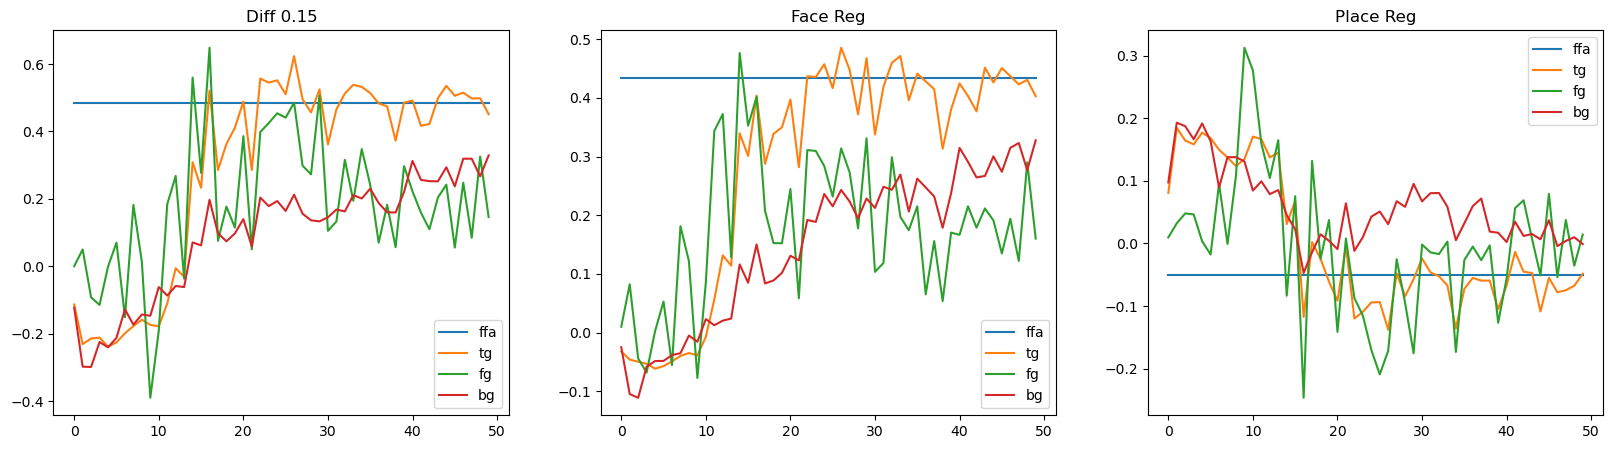

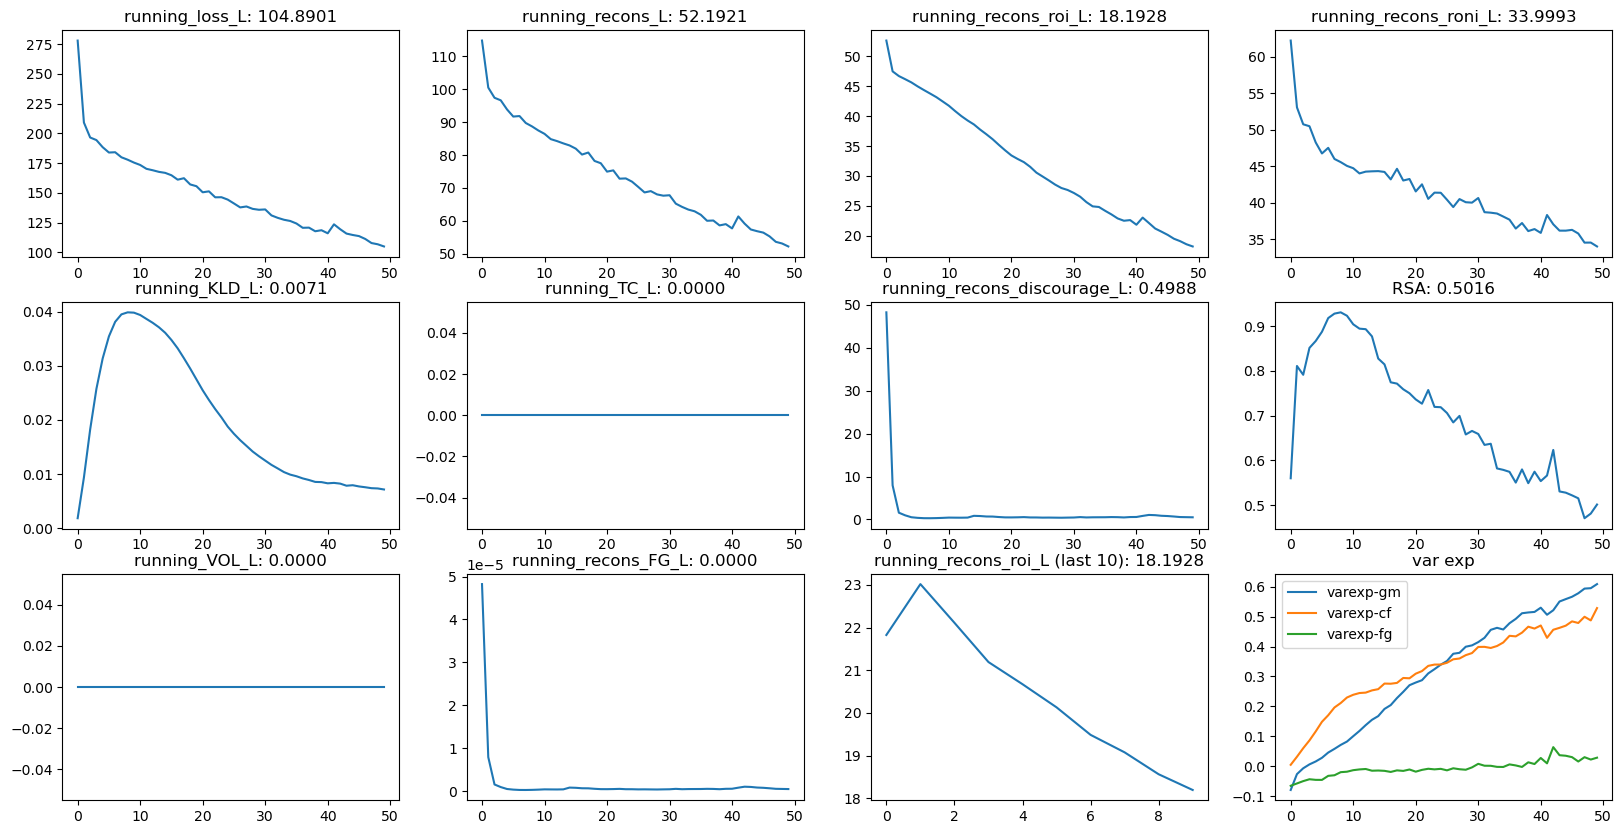

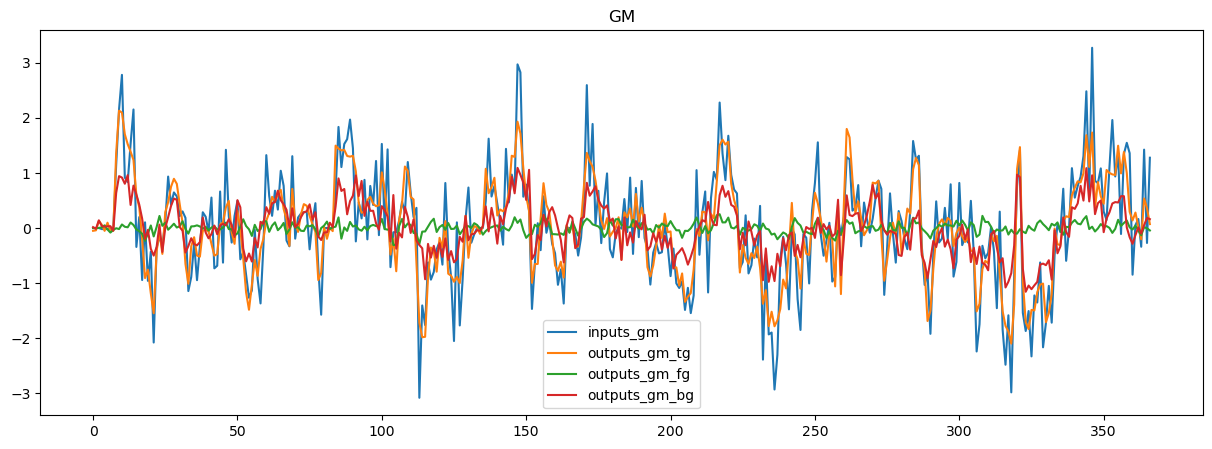

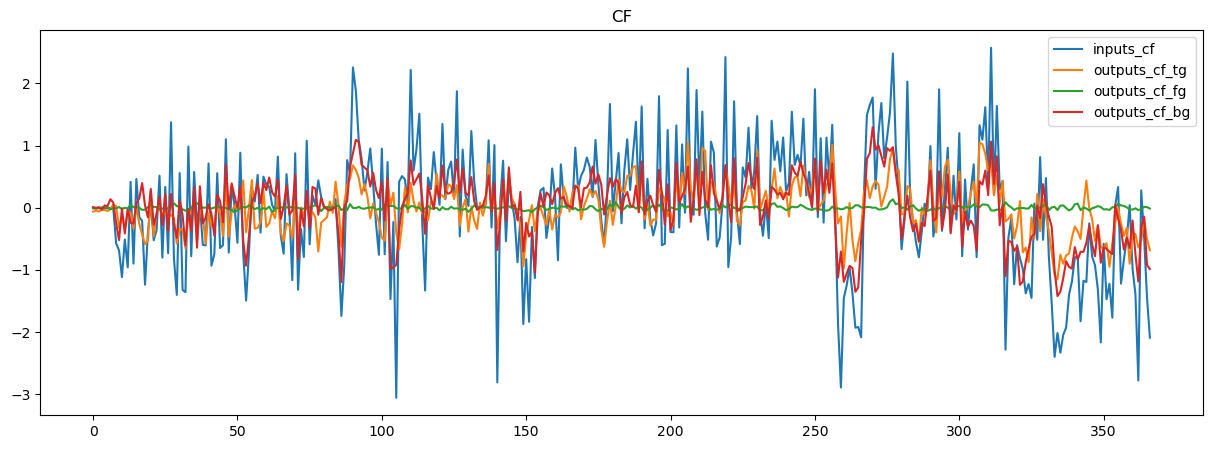

  2%|▉                                      | 50/2000 [08:28<5:30:35, 10.17s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/data/aglinska/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_387814/1416380893.py", line 121, in <cell line: 1>
    cmat_cf = np.array([(np.corrcoef(np.array((inputs_cf.detach().cpu().numpy()[:,0,:][v,:],
  File "/tmp/ipykernel_387814/1416380893.py", line 121, in <listcomp>
    cmat_cf = np.array([(np.corrcoef(np.array((inputs_cf.detach().cpu().numpy()[:,0,:][v,:],
  File "<__array_function__ internals>", line 180, in corrcoef
  File "/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py", line 2821, in corrcoef
    c = cov(x, y, rowvar, dtype=dtype)
  File "<__array_function__ internals>", line 180, in cov
  File "/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py", line 2656, in cov
    avg, w_sum = average(X, axis=1, weights=w, returned=True)
  File "<__array_fu

TypeError: object of type 'NoneType' has no len()

In [55]:
for epoch in tqdm(range(epoch_num)):  # loop over the dataset multiple times    
    running_loss = 0.0
    running_reconstruction_loss = 0.0
    running_reconstruction_loss_roi = 0.0
    running_reconstruction_loss_roni = 0.0
    running_reconstruction_loss_FG = 0.0
    running_reconstruction_loss_discourage = 0.0
    running_KLD = 0.0
    running_TC = 0.0
    running_VOL = 0.0

    track['epoch-input-gm-tg-corr'] = []
    track['epoch-input-gm-bg-corr'] = []
    track['epoch-input-gm-fg-corr'] = []
    track['epoch-input-cf-tg-corr'] = []
    track['epoch-input-cf-bg-corr'] = []
    track['epoch-input-cf-fg-corr'] = []

    track['epoch-input-gm-tg-rsa'] = []
    track['epoch-input-gm-bg-rsa'] = []
    track['epoch-input-gm-fg-rsa'] = []
    track['epoch-input-cf-tg-rsa'] = []
    track['epoch-input-cf-bg-rsa'] = []
    track['epoch-input-cf-fg-rsa'] = []

    # Iterate over data.
    dataloader_iter_in = iter(train_in)
    for i in range(len(train_in)):
        inputs_gm,inputs_cf = next(dataloader_iter_in)

        inputs_gm = inputs_gm.unsqueeze(1).float().to(device)
        inputs_cf = inputs_cf.unsqueeze(1).float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # encoder + decoder
        #[outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(inputs_gm)
        [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s] = model.forward_tg(inputs_gm)
        
        #[outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(inputs_cf)
        [outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z] = model.forward_bg(inputs_cf)
        
        outputs = torch.concat((outputs_gm,outputs_cf),1)
        loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s, outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z)
        assert ~np.isnan(loss['loss'].detach().cpu().numpy()), print(loss) ; 'loss is NaN'
        loss['loss'].backward()
        optimizer.step()

        
        running_loss += loss['loss']
        running_reconstruction_loss += loss['Reconstruction_Loss']
        running_reconstruction_loss_roi += loss['recons_loss_roi']
        running_reconstruction_loss_roni += loss['recons_loss_roni'] 
        running_reconstruction_loss_FG += loss['recons_loss_fg'] 
        running_reconstruction_loss_discourage += loss['recons_loss_discourage']
        running_KLD += loss['KLD']   
        running_TC += loss['total_contrastive_loss'].detach()  
        running_VOL += loss['fg_volatility_loss']  
        

        track['epoch-input-gm-tg-corr'].append( correlate_columns(inputs_gm.cpu().detach().numpy()[:,0,:].transpose(),model.forward_tg(inputs_gm)[0].cpu().detach().numpy()[:,0,:].transpose()).mean() )
        track['epoch-input-gm-bg-corr'].append( correlate_columns(inputs_gm.cpu().detach().numpy()[:,0,:].transpose(),model.forward_bg(inputs_gm)[0].cpu().detach().numpy()[:,0,:].transpose()).mean() )
        track['epoch-input-gm-fg-corr'].append( correlate_columns(inputs_gm.cpu().detach().numpy()[:,0,:].transpose(),model.forward_fg(inputs_gm)[0].cpu().detach().numpy()[:,0,:].transpose()).mean() )
        track['epoch-input-cf-tg-corr'].append( correlate_columns(inputs_cf.cpu().detach().numpy()[:,0,:].transpose(),model.forward_tg(inputs_cf)[0].cpu().detach().numpy()[:,0,:].transpose()).mean() )
        track['epoch-input-cf-bg-corr'].append( correlate_columns(inputs_cf.cpu().detach().numpy()[:,0,:].transpose(),model.forward_bg(inputs_cf)[0].cpu().detach().numpy()[:,0,:].transpose()).mean() )
        track['epoch-input-cf-fg-corr'].append( correlate_columns(inputs_cf.cpu().detach().numpy()[:,0,:].transpose(),model.forward_fg(inputs_cf)[0].cpu().detach().numpy()[:,0,:].transpose()).mean() )

        track['epoch-input-gm-tg-rsa'].append( np.corrcoef(get_triu(make_RDM(inputs_gm.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_tg(inputs_gm)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1] )
        track['epoch-input-gm-bg-rsa'].append( np.corrcoef(get_triu(make_RDM(inputs_gm.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_bg(inputs_gm)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1] )
        track['epoch-input-gm-fg-rsa'].append( np.corrcoef(get_triu(make_RDM(inputs_gm.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_fg(inputs_gm)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1] )
        track['epoch-input-cf-tg-rsa'].append( np.corrcoef(get_triu(make_RDM(inputs_cf.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_tg(inputs_cf)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1] )
        track['epoch-input-cf-bg-rsa'].append( np.corrcoef(get_triu(make_RDM(inputs_cf.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_bg(inputs_cf)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1] )
        track['epoch-input-cf-fg-rsa'].append( np.corrcoef(get_triu(make_RDM(inputs_cf.cpu().detach().numpy()[:,0,:],metric='correlation')),get_triu(make_RDM(model.forward_fg(inputs_cf)[0].cpu().detach().numpy()[:,0,:],metric='correlation')))[0,1] )



    track['input-gm-tg-corr'].append(np.array(track['epoch-input-gm-tg-corr']).mean())
    track['input-gm-bg-corr'].append(np.array(track['epoch-input-gm-bg-corr']).mean())
    track['input-gm-fg-corr'].append(np.array(track['epoch-input-gm-fg-corr']).mean())
    track['input-cf-tg-corr'].append(np.array(track['epoch-input-cf-tg-corr']).mean())
    track['input-cf-bg-corr'].append(np.array(track['epoch-input-cf-bg-corr']).mean())
    track['input-cf-fg-corr'].append(np.array(track['epoch-input-cf-fg-corr']).mean())

    track['input-gm-tg-rsa'].append(np.array(track['epoch-input-gm-tg-rsa']).mean())
    track['input-gm-bg-rsa'].append(np.array(track['epoch-input-gm-bg-rsa']).mean())
    track['input-gm-fg-rsa'].append(np.array(track['epoch-input-gm-fg-rsa']).mean())
    track['input-cf-tg-rsa'].append(np.array(track['epoch-input-cf-tg-rsa']).mean())
    track['input-cf-bg-rsa'].append(np.array(track['epoch-input-cf-bg-rsa']).mean())
    track['input-cf-fg-rsa'].append(np.array(track['epoch-input-cf-fg-rsa']).mean())
    
    track['TG-BG-SL-RSA'].append( np.corrcoef(get_triu(make_RDM(tg_mu_s.detach().cpu().numpy())),get_triu(make_RDM(tg_mu_z.detach().cpu().numpy())))[0,1] )
    
    outputs_gm_tg = model.forward_tg(inputs_gm)[0]
    outputs_gm_fg = model.forward_fg(inputs_gm)[0]
    outputs_gm_bg = model.forward_bg(inputs_gm)[0]
    
    outputs_cf_tg = model.forward_tg(inputs_cf)[0]
    outputs_cf_fg = model.forward_fg(inputs_cf)[0]
    outputs_cf_bg = model.forward_bg(inputs_cf)[0]

    SS_model = ((inputs_gm.detach().cpu().numpy()[:,0,:]-outputs_gm.detach().cpu().numpy()[:,0,:])**2).sum()
    SS_total = ((inputs_gm.detach().cpu().numpy()[:,0,:]-inputs_gm.detach().cpu().numpy()[:,0,:].mean(axis=0))**2).sum()
    varexp_gm = 1-(SS_model/SS_total)
    
    SS_model = ((inputs_cf.detach().cpu().numpy()[:,0,:]-outputs_cf.detach().cpu().numpy()[:,0,:])**2).sum()
    SS_total = ((inputs_cf.detach().cpu().numpy()[:,0,:]-outputs_cf.detach().cpu().numpy()[:,0,:].mean(axis=0))**2).sum()
    varexp_cf = 1-(SS_model/SS_total)
    
    SS_model = ((inputs_gm.detach().cpu().numpy()[:,0,:]-outputs_gm_fg.detach().cpu().numpy()[:,0,:])**2).sum()
    SS_total = ((inputs_gm.detach().cpu().numpy()[:,0,:]-inputs_gm.detach().cpu().numpy()[:,0,:].mean(axis=0))**2).sum()
    varexp_fg = 1-(SS_model/SS_total)

    track['varexp-gm'].append(varexp_gm)
    track['varexp-cf'].append(varexp_cf)
    track['varexp-fg'].append(varexp_fg)

    cmat_bg = np.array([(np.corrcoef(np.array((inputs_gm.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_tg.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_fg.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_bg.detach().cpu().numpy()[:,0,:][v,:])))) for v in range(inputs_gm.shape[0])]).mean(axis=0)

    cmat_cf = np.array([(np.corrcoef(np.array((inputs_cf.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_tg.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_fg.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_bg.detach().cpu().numpy()[:,0,:][v,:])))) for v in range(inputs_gm.shape[0])]).mean(axis=0)

    track['cmat_bg'].append(cmat_bg)
    track['cmat_cf'].append(cmat_cf)

    if do_synth_data==True:
        
        probe = torch.tensor(obs_list[0:64,np.newaxis,:]).float().to(device)

        recon_probe_tg = model.forward_tg(probe)[0]
        recon_probe_fg = model.forward_fg(probe)[0]
        recon_probe_bg = model.forward_bg(probe)[0]
        
        track['synth-GM-GT-TG'].append( correlate_columns(recon_probe_tg.detach().cpu().numpy()[:,0,:].transpose(),gound_truth[0:64,:].transpose()).mean() )
        track['synth-GM-GT-FG'].append( correlate_columns(recon_probe_fg.detach().cpu().numpy()[:,0,:].transpose(),gound_truth[0:64,:].transpose()).mean() )
        track['synth-GM-GT-BG'].append( correlate_columns(recon_probe_bg.detach().cpu().numpy()[:,0,:].transpose(),gound_truth[0:64,:].transpose()).mean() ) 
        
        probe = torch.tensor(noi_list[0:64,np.newaxis,:]).float().to(device)
        
        recon_probe_tg = model.forward_tg(probe)[0]
        recon_probe_fg = model.forward_fg(probe)[0]
        recon_probe_bg = model.forward_bg(probe)[0]
        
        track['synth-CF-GT-TG'].append( correlate_columns(recon_probe_tg.detach().cpu().numpy()[:,0,:].transpose(),gound_truth[0:64,:].transpose()).mean() )
        track['synth-CF-GT-FG'].append( correlate_columns(recon_probe_fg.detach().cpu().numpy()[:,0,:].transpose(),gound_truth[0:64,:].transpose()).mean() )
        track['synth-CF-GT-BG'].append( correlate_columns(recon_probe_bg.detach().cpu().numpy()[:,0,:].transpose(),gound_truth[0:64,:].transpose()).mean() ) 

    epoch_running_loss = running_loss / (len(train_in)*2)
    epoch_running_reconstruction_loss = running_reconstruction_loss / (len(train_in)*2)
    running_reconstruction_loss_roi = running_reconstruction_loss_roi / (len(train_in)*2)
    running_reconstruction_loss_roni = running_reconstruction_loss_roni / (len(train_in)*2)
    running_reconstruction_loss_FG = running_reconstruction_loss_FG / (len(train_in)*2)
    running_reconstruction_loss_discourage = running_reconstruction_loss_discourage / (len(train_in)*2)

    epoch_running_KLD = running_KLD / (len(train_in)*2)
    epoch_running_TC = running_TC / (len(train_in)*2)
    running_VOL = running_VOL / (len(train_in)*2)
    
    running_loss_L.append(epoch_running_loss.cpu().detach().numpy())
    running_recons_L.append(epoch_running_reconstruction_loss.cpu().detach().numpy())
    running_KLD_L.append(epoch_running_KLD.cpu().detach().numpy())
    running_TC_L.append(epoch_running_TC.cpu().detach().numpy())
    running_recons_roi_L.append(running_reconstruction_loss_roi.cpu().detach().numpy())
    running_recons_roni_L.append(running_reconstruction_loss_roni.cpu().detach().numpy())
    running_recons_FG_L.append(running_reconstruction_loss_FG.cpu().detach().numpy())
    running_recons_discourage_L.append( running_reconstruction_loss_discourage.cpu().detach().numpy() )
    running_VOL_L.append( running_VOL.cpu().detach().numpy() )
    track['corr_w_reg'].append(get_corr_w_reg())

    plt.close()
    sys.stdout.flush()
    display.clear_output(wait=True);
    display.display(plt.gcf());

    plot_r_w_reg();plt.show()
    show_dashboard();plt.show()
    show_voxel_recon();plt.show()
    #plt.tight_layout()
    plt.show()

In [ ]:
if do_synth_data==False:
    
    ffa_batch = ffa_list[0:batch_size,:]
    ffa_batch = torch.tensor(ffa_batch[:,np.newaxis,:]).to(device)
    
    ffa_tg = model.forward_tg(ffa_batch)
    ffa_tg = ffa_tg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_fg = model.forward_fg(ffa_batch)
    ffa_fg = ffa_fg[0].detach().cpu().numpy()[:,0,:]
    
    ffa_bg = model.forward_bg(ffa_batch)
    ffa_bg = ffa_bg[0].detach().cpu().numpy()[:,0,:]
    
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.plot(ffa_list[:,:].mean(axis=0))
    plt.plot(noi_list.mean(axis=0))
    plt.plot(face_reg)
    plt.plot(place_reg)
    
    #c = np.array([np.corrcoef(ffa_list[v,:],face_reg)[0,1] for v in range(ffa_list.shape[0])]).mean()
    c = np.corrcoef(ffa_list[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'ffa activity + regs: {c:.2f}')
    
    plt.subplot(2,2,2)
    plt.plot(ffa_tg[:,:].mean(axis=0))
    plt.plot(face_reg*ffa_tg[:,:].mean(axis=0).max())
    plt.plot(place_reg*ffa_tg[:,:].mean(axis=0).max())
    #c = np.array([np.corrcoef(ffa_tg[v,:],face_reg)[0,1] for v in range(ffa_list.shape[0])]).mean()
    c = np.corrcoef(ffa_tg[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'ffa TG + regs {c:.2f}')
    
    plt.subplot(2,2,3)
    plt.plot(ffa_fg[:,:].mean(axis=0))
    plt.plot(face_reg*ffa_fg[:,:].mean(axis=0).max())
    plt.plot(place_reg*ffa_fg[:,:].mean(axis=0).max())
    #c = np.array([np.corrcoef(ffa_fg[v,:],face_reg)[0,1] for v in range(ffa_list.shape[0])]).mean()
    c = np.corrcoef(ffa_fg[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'ffa FG + regs {c:.2f}')
    
    plt.subplot(2,2,4)
    plt.plot(ffa_bg[:,:].mean(axis=0))
    plt.plot(face_reg*ffa_bg[:,:].mean(axis=0).max())
    plt.plot(place_reg*ffa_bg[:,:].mean(axis=0).max())
    #c = np.array([np.corrcoef(ffa_bg[v,:],face_reg)[0,1] for v in range(ffa_list.shape[0])]).mean()
    c = np.corrcoef(ffa_bg[:,:].mean(axis=0),face_reg)[0,1]
    plt.title(f'ffa BG + regs {c:.2f}')

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(obs_list.mean(axis=0))
plt.plot(noi_list.mean(axis=0))
plt.plot(place_reg*obs_list[:,:].mean(axis=0).max())
plt.plot(face_reg*obs_list[:,:].mean(axis=0).max())

In [ ]:
if do_synth_data==False:
    plot_r_w_reg()

In [ ]:
if do_synth_data==True:
    plt.figure(figsize=(15,5))
    v = 0
    probe = torch.tensor(obs_list[v:v+batch_size,np.newaxis,:]).float().to(device)
    recon_probe_tg = model.forward_tg(probe)[0]
    recon_probe_fg = model.forward_fg(probe)[0]
    recon_probe_bg = model.forward_bg(probe)[0]
    
    v1=norm(probe.detach().cpu().numpy()[:,0,:][v,:]); plt.plot(v1,alpha=.5,linewidth=3)
    v2=norm(recon_probe_tg.detach().cpu().numpy()[:,0,:][v,:]);plt.plot(v2,alpha=.5,linewidth=3)
    v3=norm(recon_probe_fg.detach().cpu().numpy()[:,0,:][v,:]);plt.plot(v3,alpha=.5,linewidth=3)
    v4=norm(recon_probe_bg.detach().cpu().numpy()[:,0,:][v,:]);plt.plot(v4,alpha=.5,linewidth=3)
    v5=norm(gound_truth[v,:]); plt.plot(v5,alpha=.5,linewidth=3)
    
    plt.legend([f'input: {np.corrcoef(v1,v5)[0,1]:.2f}',f'recon_probe_tg: {np.corrcoef(v2,v5)[0,1]:.2f}',f'recon_probe_fg {np.corrcoef(v3,v5)[0,1]:.2f}',f'recon_probe_bg: {np.corrcoef(v4,v5)[0,1]:.2f}','ground-truth'])

In [ ]:
plt.imshow(np.corrcoef(inputs_gm.detach().cpu().numpy()[:,0,:],inputs_cf.detach().cpu().numpy()[:,0,:]))

In [ ]:
outputs_gm_tg = model.forward_tg(inputs_gm)[0]
outputs_gm_fg = model.forward_fg(inputs_gm)[0]
outputs_gm_bg = model.forward_bg(inputs_gm)[0]

outputs_cf_tg = model.forward_tg(inputs_cf)[0]
outputs_cf_fg = model.forward_fg(inputs_cf)[0]
outputs_cf_bg = model.forward_bg(inputs_cf)[0]

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.heatmap(np.array([(np.corrcoef(np.array((inputs_gm.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_tg.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_fg.detach().cpu().numpy()[:,0,:][v,:],
outputs_gm_bg.detach().cpu().numpy()[:,0,:][v,:])))) for v in range(inputs_gm.shape[0])]).mean(axis=0),annot=True,xticklabels=['Input','BG+SL','0+SL','BG+0'],
            yticklabels=['Input','BG+SL','0+SL','BG+0'])

plt.title('ROI')

plt.subplot(1,2,2)
sns.heatmap(np.array([(np.corrcoef(np.array((inputs_cf.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_tg.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_fg.detach().cpu().numpy()[:,0,:][v,:],
outputs_cf_bg.detach().cpu().numpy()[:,0,:][v,:])))) for v in range(inputs_gm.shape[0])]).mean(axis=0),annot=True,xticklabels=['Input','BG+SL','0+SL','BG+0'],
            yticklabels=['Input','BG+SL','0+SL','BG+0'])

plt.title('RONI')

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(np.array(track['cmat_bg'])[:,0,1]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,0,2]),linewidth=5)
plt.plot(np.array(np.array(track['cmat_bg'])[:,0,3]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,1,2]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,1,3]))
plt.plot(np.array(np.array(track['cmat_bg'])[:,2,3]))
plt.legend(['input:BG+SL', 'input:0+SL','input:BG+0','BG+SL:0+SL','BG+SL:0+SL','0+SL:0+BG'])

plt.subplot(1,2,2)
plt.plot(np.array(np.array(track['cmat_cf'])[:,0,1]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,0,2]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,0,3]),linewidth=5)
plt.plot(np.array(np.array(track['cmat_cf'])[:,1,2]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,1,3]))
plt.plot(np.array(np.array(track['cmat_cf'])[:,2,3]))
plt.legend(['input:BG+SL', 'input:0+SL','input:BG+0','BG+SL:0+SL','BG+SL:0+SL','0+SL:0+BG'])

In [ ]:
show_voxel_recon()

In [ ]:
np.array([np.corrcoef(inputs_gm.cpu().detach().numpy()[:,0,:][v,:],outputs_gm.cpu().detach().numpy()[:,0,:][v,:])[0,1] for v in range(batch_size)]).mean()

In [ ]:
np.array([np.corrcoef(inputs_cf.cpu().detach().numpy()[:,0,:][v,:],outputs_cf.cpu().detach().numpy()[:,0,:][v,:])[0,1] for v in range(batch_size)]).mean()

In [ ]:
show_dashboard()

In [ ]:
   # track['input-gm-tg-corr'].append(np.array(track['epoch-input-gm-tg-corr']).mean())
   #  track['input-gm-bg-corr'].append(np.array(track['epoch-input-gm-bg-corr']).mean())
   #  track['input-gm-fg-corr'].append(np.array(track['epoch-input-gm-fg-corr']).mean())
   #  track['input-cf-tg-corr'].append(np.array(track['epoch-input-cf-tg-corr']).mean())
   #  track['input-cf-bg-corr'].append(np.array(track['epoch-input-cf-bg-corr']).mean())
   #  track['input-cf-fg-corr'].append(np.array(track['epoch-input-cf-fg-corr']).mean())

   #  track['input-gm-tg-rsa'].append(np.array(track['epoch-input-gm-tg-rsa']).mean())
   #  track['input-gm-bg-rsa'].append(np.array(track['epoch-input-gm-bg-rsa']).mean())
   #  track['input-gm-fg-rsa'].append(np.array(track['epoch-input-gm-fg-rsa']).mean())
   #  track['input-cf-tg-rsa'].append(np.array(track['epoch-input-cf-tg-rsa']).mean())
   #  track['input-cf-bg-rsa'].append(np.array(track['epoch-input-cf-bg-rsa']).mean())
   #  track['input-cf-fg-rsa'].append(np.array(track['epoch-input-cf-fg-rsa']).mean())

In [ ]:
keys = ['input-gm-tg-corr',
'input-gm-bg-corr',
'input-gm-fg-corr',
'input-cf-tg-corr',
'input-cf-bg-corr',
'input-cf-fg-corr',
'input-gm-tg-rsa',
'input-gm-bg-rsa',
'input-gm-fg-rsa',
'input-cf-tg-rsa',
'input-cf-bg-rsa',
'input-cf-fg-rsa',]

plt.figure(figsize=(20,15))
for i, key in enumerate(keys):
    plt.subplot(4,3,i+1)
    plt.plot(track[key]);plt.title(key+f': {track[key][-1]:.2f}')

plt.subplots_adjust()

In [ ]:
if do_synth_data==True:
    plt.figure(figsize=(20,10))
    plt.subplot(2,3,1);plt.plot(track['synth-GM-GT-TG']);plt.title('synth-GM-GT-TG')
    plt.subplot(2,3,2);plt.plot(track['synth-GM-GT-FG']);plt.title('synth-GM-GT-FG')
    plt.subplot(2,3,3);plt.plot(track['synth-GM-GT-BG']);plt.title('synth-GM-GT-BG')
    
    plt.subplot(2,3,4);plt.plot(track['synth-CF-GT-TG']);plt.title('synth-CF-GT-TG')
    plt.subplot(2,3,5);plt.plot(track['synth-CF-GT-FG']);plt.title('synth-CF-GT-FG')
    plt.subplot(2,3,6);plt.plot(track['synth-CF-GT-BG']);plt.title('synth-CF-GT-BG')

In [ ]:
# plt.figure(figsize=(20,10))
# for i,key in enumerate(track.keys()):
#     plt.subplot(2,3,i+1)
#     plt.plot(track[key])
#     plt.title(key)

# plt.subplots_adjust()

In [ ]:
# dataloader_iter_in = iter(train_in)
# inputs_gm,inputs_cf = next(dataloader_iter_in)
# inputs_gm = inputs_gm.unsqueeze(1).float().to(device)
# inputs_cf = inputs_cf.unsqueeze(1).float().to(device)
# [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(inputs_gm)
# [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(inputs_cf)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
v1 = inputs_gm.detach().cpu().numpy()[0,0,:]
v2 = outputs_gm.detach().cpu().numpy()[0,0,:]

plt.plot(v1,alpha=.5)
plt.plot(v2,alpha=.5)
plt.title(f'GM in/out: corr: {np.corrcoef(v1,v2)[0,1]:.2f}')
plt.legend(['Input','Output'])

plt.subplot(1,2,2)
v1 = inputs_cf.detach().cpu().numpy()[0,0,:]
v2 = outputs_cf.detach().cpu().numpy()[0,0,:]

plt.plot(v1,alpha=.5)
plt.plot(v2,alpha=.5)
plt.legend(['Input','Output'])
plt.title(f'CF in/out: corr: {np.corrcoef(v1,v2)[0,1]:.2f}')

In [ ]:
brain_scaler = Scaler(brain_gm)
brain_list = brain_scaler.transform(brain_gm)

In [ ]:
#func_data = obs_list
def get_reconstructions(func_data,mode='TG'):
    
    denoise_inputs = DenoiseDataset(func_data)
    denoise_in = torch.utils.data.DataLoader(denoise_inputs, batch_size=512,shuffle=False, num_workers=1)
    denoise_iter_in = iter(denoise_in)
    
    for i in tqdm(range(len(denoise_in))):
        inputs = next(denoise_iter_in)
        inputs = inputs.unsqueeze(1).float().to(device)
        
        #func_output = model.generate(inputs)
        
        if mode=='TG':
            func_output = model.forward_tg(inputs)[0]
        elif mode=='BG':
            func_output = model.forward_bg(inputs)[0]
        elif mode=='FG':
            func_output = model.forward_fg(inputs)[0]
            
        func_output_np = func_output.squeeze().cpu().detach().numpy()
        if i == 0:
            outputs_all = func_output_np 
        else:
            outputs_all = np.concatenate((outputs_all,func_output_np), axis = 0)
    return outputs_all

In [ ]:
outputs_all_TG = get_reconstructions(brain_list,mode='TG')

In [ ]:
outputs_all_BG = get_reconstructions(brain_list,mode='BG')

In [ ]:
outputs_all_FG = get_reconstructions(brain_list,mode='FG')

In [ ]:
#plt.plot(epi_flat[gm_flat==1,:].mean(axis=0))

In [ ]:
#plt.plot(obs_scale.inverse_transform(outputs_all_TG)[gm_flat,:].mean(axis=0))

In [ ]:
if do_synth_data==True:
    outputs_all_TG = get_reconstructions(obs_list,mode='TG')
    outputs_all_BG = get_reconstructions(obs_list,mode='BG')
    outputs_all_FG = get_reconstructions(obs_list,mode='FG')

In [ ]:
v = 10000
plt.figure(figsize=(15,5))
plt.plot(outputs_all_TG[v,:],'b-',alpha=.5)
plt.plot(outputs_all_FG[v,:],'g-',alpha=.5)
plt.plot(outputs_all_BG[v,:],'r-',alpha=.5)
plt.legend(['TG','FG','BG'])

In [ ]:
func_data = brain_list
obs_scale = brain_scaler

v = 62600+5000
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(func_data[v,:])
plt.plot(outputs_all_TG[v,:])
plt.legend(['func_data','outputs_all'])
plt.title(f'corr: {np.corrcoef(func_data[v,:],outputs_all_TG[v,:])[0,1]:.2f}')

plt.subplot(1,2,2)
plt.plot(brain_gm[v,:])

descaled = obs_scale.inverse_transform(outputs_all_TG)
if do_norm==True:
    descaled = obs_scale.inverse_transform(outputs_all_TG * (max_obs_list-min_obs_list) + min_obs_list)
plt.plot(descaled[v,:])
plt.title(f'corr: {np.corrcoef(brain_gm[v,:],descaled[v,:])[0,1]:.2f}')
plt.legend(['Raw in','Out inv-scaled'])
plt.suptitle('outputs_all_TG')


#v = 500
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(func_data[v,:])
plt.plot(outputs_all_BG[v,:])
plt.legend(['func_data','outputs_all'])
plt.title(f'corr: {np.corrcoef(func_data[v,:],outputs_all_BG[v,:])[0,1]:.2f}')

plt.subplot(1,2,2)
plt.plot(brain_gm[v,:])

descaled = obs_scale.inverse_transform(outputs_all_BG)
if do_norm==True:
    descaled = obs_scale.inverse_transform(outputs_all_BG * (max_obs_list-min_obs_list) + min_obs_list)
plt.plot(descaled[v,:])
plt.title(f'corr: {np.corrcoef(brain_gm[v,:],descaled[v,:])[0,1]:.2f}')
plt.legend(['Raw in','Out inv-scaled'])
plt.suptitle('outputs_all_BG')


#v = 500
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(func_data[v,:])
plt.plot(outputs_all_FG[v,:])
plt.legend(['func_data','outputs_all'])
plt.title(f'corr: {np.corrcoef(func_data[v,:],outputs_all_FG[v,:])[0,1]:.2f}')

plt.subplot(1,2,2)
plt.plot(brain_gm[v,:])

descaled = obs_scale.inverse_transform(outputs_all_FG)
if do_norm==True:
    descaled = obs_scale.inverse_transform(outputs_all_FG * (max_obs_list-min_obs_list) + min_obs_list)
plt.plot(descaled[v,:])
plt.title(f'corr: {np.corrcoef(func_data[v,:],descaled[v,:])[0,1]:.2f}')
plt.legend(['Raw in','Out inv-scaled'])
plt.suptitle('outputs_all_FG')

In [ ]:
outdir = os.path.join('../Data/050-Data-DeepCor-ed',analysis_name)
print(outdir)

In [ ]:
safe_mkdir(outdir)

In [ ]:
if do_synth_data==False:
    
    denoised_flat = np.zeros(epi_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3,:] = obs_scale.inverse_transform(outputs_all_TG) # Takes into account std0 voxels
    denoised_mat = denoised_flat.reshape(epi.shape)
    denoised = epi.new_image_like(denoised_mat)
    #ofn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-DEEPCOR-TG-{rep}_bold.nii'.format(sub=sub,r=r,rep=rep))
    ofn = os.path.join(outdir,f'deepcor-TG-{sub}-run-{r}-rep-{rep}.nii.gz')
    denoised.to_filename(ofn)


    denoised_flat = np.zeros(epi_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3,:] = obs_scale.inverse_transform(outputs_all_BG) # Takes into account std0 voxels
    denoised_mat = denoised_flat.reshape(epi.shape)
    denoised = epi.new_image_like(denoised_mat)
    #ofn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-DEEPCOR-BG-{rep}_bold.nii'.format(sub=sub,r=r,rep=rep))
    ofn = os.path.join(outdir,f'deepcor-BG-{sub}-run-{r}-rep-{rep}.nii.gz')
    denoised.to_filename(ofn)

    denoised_flat = np.zeros(epi_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3,:] = obs_scale.inverse_transform(outputs_all_FG) # Takes into account std0 voxels
    denoised_mat = denoised_flat.reshape(epi.shape)
    denoised = epi.new_image_like(denoised_mat)
    #ofn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-DEEPCOR-FG-{rep}_bold.nii'.format(sub=sub,r=r,rep=rep))
    ofn = os.path.join(outdir,f'deepcor-FG-{sub}-run-{r}-rep-{rep}.nii.gz')
    denoised.to_filename(ofn)

    denoised_flat = np.zeros(epi_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3,:] = obs_scale.inverse_transform(outputs_all_TG)-obs_scale.inverse_transform(outputs_all_BG) # Takes into account std0 voxels
    denoised_mat = denoised_flat.reshape(epi.shape)
    denoised = epi.new_image_like(denoised_mat)
    #ofn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-DEEPCOR-twin-{rep}_bold.nii'.format(sub=sub,r=r,rep=rep))
    ofn = os.path.join(outdir,f'deepcor-twin-{sub}-run-{r}-rep-{rep}.nii.gz')
    denoised.to_filename(ofn)

In [ ]:
save_derivatives=True
if all((save_derivatives==True,do_synth_data==False)):
    ## Face Regressors
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_TG.transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2face-TG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)

    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_BG.transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2face-BG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)
    
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_FG.transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2face-FG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)
    
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns((outputs_all_TG-outputs_all_BG).transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2face-twin-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)

    ## Place Regressors
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_TG.transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2place-TG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)

    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_BG.transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2place-BG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)
    
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_FG.transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2place-FG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)
    
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns((outputs_all_TG-outputs_all_BG).transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corr2place-twin-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)


    ## Corr-diff
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_TG.transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())-correlate_columns(outputs_all_TG.transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corrDiff-TG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)

    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_BG.transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())-correlate_columns(outputs_all_BG.transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corrDiff-BG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)
    
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns(outputs_all_FG.transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())-correlate_columns(outputs_all_FG.transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corrDiff-FG-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)
    
    denoised_flat = np.zeros(gm_flat.shape)
    vec1 = brain_flat==1
    vec2 = epi_flat.std(axis=1)!=0.0
    vec3 = vec1*vec2
    denoised_flat[vec3] = correlate_columns((outputs_all_TG-outputs_all_BG).transpose(),np.array([face_reg for _ in range(outputs_all_TG.shape[0])]).transpose())-correlate_columns((outputs_all_TG-outputs_all_BG).transpose(),np.array([place_reg for _ in range(outputs_all_TG.shape[0])]).transpose())
    denoised_mat = denoised_flat.reshape(gm.shape)
    denoised = gm.new_image_like(denoised_mat)
    ofn = os.path.join(outdir,f'corrDiff-twin-{sub}-run-{r}-rep-{rep}.nii')
    denoised.to_filename(ofn)

    import pickle
    track_ofn = os.path.join(outdir,f'tracked-vars-{sub}-run-{r}-rep-{rep}.pickle')
    with open(track_ofn, 'wb') as handle:
        pickle.dump(track, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open(track_ofn,'rb') as file:
#     object_file = pickle.load(file)

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(correlate_columns(brain_gm,outputs_all_TG))
plt.title('Time Point Similarity')
plt.subplot(1,2,2)
plt.hist(correlate_columns(brain_gm.transpose(),outputs_all_TG.transpose()))
plt.title('Voxel Similarity')
plt.suptitle('outputs_all_TG')


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(correlate_columns(brain_gm,outputs_all_BG))
plt.title('Time Point Similarity')
plt.subplot(1,2,2)
plt.hist(correlate_columns(brain_gm.transpose(),outputs_all_BG.transpose()))
plt.title('Voxel Similarity')
plt.suptitle('outputs_all_BG')


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(correlate_columns(brain_gm,outputs_all_FG))
plt.title('Time Point Similarity')
plt.subplot(1,2,2)
plt.hist(correlate_columns(brain_gm.transpose(),outputs_all_FG.transpose()))
plt.title('Voxel Similarity')
plt.suptitle('outputs_all_FG')

In [ ]:
if do_synth_data==True:
    pca = PCA(n_components=5)
    comps = pca.fit_transform(func_cf.transpose())
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(comps,func_gm.transpose())
    predicted = lin_reg.predict(comps)
    residuals = func_gm-predicted.transpose()
else:
    pca = PCA(n_components=5)
    comps = pca.fit_transform(func_cf.transpose())
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit(comps,brain_gm.transpose())
    predicted = lin_reg.predict(comps)
    residuals = brain_gm-predicted.transpose()

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(correlate_columns(residuals,brain_gm))
plt.title('Time Point Similarity')
plt.subplot(1,2,2)
plt.hist(correlate_columns(brain_gm.transpose(),residuals.transpose()))
plt.title('Voxel Similarity')
plt.suptitle('COMPCOR')

In [ ]:
SS_mean = ((brain_gm-brain_gm.mean(axis=1)[:,np.newaxis])**2).mean()
SS_deepcorr_TG = ((brain_gm-obs_scale.inverse_transform(outputs_all_TG))**2).mean()
SS_deepcorr_BG = ((brain_gm-obs_scale.inverse_transform(outputs_all_BG))**2).mean()
SS_deepcorr_FG = ((brain_gm-obs_scale.inverse_transform(outputs_all_FG))**2).mean()
SS_compcorr = ((brain_gm-brain_gm.mean(axis=-1)[:,np.newaxis]-residuals)**2).mean()

In [ ]:
# SS_mean = ((gound_truth*240-func_gm.mean(axis=0))**2).mean()
# SS_deepcorr = ((gound_truth*240-obs_scale.inverse_transform(outputs_all))**2).mean()
# SS_compcorr = ((gound_truth*240-residuals)**2).mean()

In [ ]:
(SS_mean,SS_compcorr,SS_deepcorr_TG,SS_deepcorr_BG,SS_deepcorr_FG)

In [ ]:
1-(SS_deepcorr_TG/SS_mean)

In [ ]:
1-(SS_deepcorr_BG/SS_mean)

In [ ]:
1-(SS_deepcorr_FG/SS_mean)

In [ ]:
1-(SS_compcorr/SS_mean)

In [ ]:
plt.figure(figsize=(20,5))
v = 500
plt.plot(brain_gm[v,:],alpha=.5,linewidth=3)
plt.plot(residuals[v,:]+brain_gm[v,:].mean(),alpha=.5,linewidth=3)
plt.plot(obs_scale.inverse_transform(outputs_all_TG)[v,:],alpha=.5,linewidth=3)
plt.plot(obs_scale.inverse_transform(outputs_all_BG)[v,:],alpha=.5,linewidth=3)
plt.plot(obs_scale.inverse_transform(outputs_all_FG)[v,:],alpha=.5,linewidth=3)

plt.legend(['ORIG','COMPCOR','DEEPCOR-TG','DEEPCOR-BG','DEEPCOR-FG'])

In [ ]:
plt.figure(figsize=(20,5))
v = 500
#plt.plot(brain_gm[v,:],alpha=.5,linewidth=3)
#plt.plot(residuals[v,:]+brain_gm[v,:].mean(),alpha=.5,linewidth=3)
plt.plot(obs_scale.inverse_transform(outputs_all_TG)[v,:],alpha=.5,linewidth=3)
#plt.plot(obs_scale.inverse_transform(outputs_all_BG)[v,:],alpha=.5,linewidth=3)
plt.plot(obs_scale.inverse_transform(outputs_all_FG)[v,:],alpha=.5,linewidth=3)
#plt.title(['ORIG','COMPCOR','DEEPCOR-TG','DEEPCOR-BG','DEEPCOR-FG'][2])

In [ ]:
# plt.figure(figsize=(20,5))
# v = 500
# #plt.plot(brain_gm[v,:],alpha=.5,linewidth=3)
# #plt.plot(residuals[v,:]+brain_gm[v,:].mean(),alpha=.5,linewidth=3)
# #plt.plot(obs_scale.inverse_transform(outputs_all_TG)[v,:],alpha=.5,linewidth=3)
# #plt.plot(obs_scale.inverse_transform(outputs_all_BG)[v,:],alpha=.5,linewidth=3)
# plt.plot(obs_scale.inverse_transform(outputs_all_TG)[v,:]-obs_scale.inverse_transform(outputs_all_BG)[v,:],alpha=.5,linewidth=3)
# plt.title(['ORIG','COMPCOR','DEEPCOR-TG','DEEPCOR-BG','DEEPCOR-FG'][2])

In [ ]:
#plt.plot(obs_scale.inverse_transform(outputs_all).mean(axis=0))

In [ ]:
print('Data-CompCorr corr: {:.4f}'.format(correlate_columns(brain_gm.transpose(),residuals.transpose()).mean()))
print('')
print('Data-DeepCor-TG corr: {:.4f}'.format(correlate_columns(brain_gm.transpose(),obs_scale.inverse_transform(outputs_all_TG).transpose()).mean()))
print('')
print('Data-DeepCor-BG corr: {:.4f}'.format(correlate_columns(brain_gm.transpose(),obs_scale.inverse_transform(outputs_all_BG).transpose()).mean()))
print('')
print('Data-DeepCor-FG corr: {:.4f}'.format(correlate_columns(brain_gm.transpose(),obs_scale.inverse_transform(outputs_all_FG).transpose()).mean()))

print('')
print('CompCor-DeepCor-TG corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_TG).transpose(),residuals.transpose()).mean()))
print('')
print('CompCor-DeepCor-BG corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_BG).transpose(),residuals.transpose()).mean()))
print('')
print('CompCor-DeepCor-FG corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_FG).transpose(),residuals.transpose()).mean()))

In [ ]:
func_gm.shape

In [ ]:
if do_synth_data==True:
    print('Data-Grounth-Truth corr: {:.4f}'.format(correlate_columns(func_gm.transpose(),gound_truth.transpose()).mean()))
    print('CompCor-Grounth-Truth corr: {:.4f}'.format(correlate_columns(residuals.transpose(),gound_truth.transpose()).mean()))
    print('DeepCor-TG-Grounth-Truth corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_TG).transpose(),gound_truth.transpose()).mean()))
    print('DeepCor-BG-Grounth-Truth corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_BG).transpose(),gound_truth.transpose()).mean()))
    print('DeepCor-FG-Grounth-Truth corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_FG).transpose(),gound_truth.transpose()).mean()))
    print('DeepCor-TG-minus-BG-Grounth-Truth corr: {:.4f}'.format(correlate_columns(obs_scale.inverse_transform(outputs_all_TG).transpose()-obs_scale.inverse_transform(outputs_all_BG).transpose(),gound_truth.transpose()).mean()))

In [ ]:
#fmri_img = nib.load(epi_fn.format(sub=sub,r=r))
#fmri_img = nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','COMPCORR_bold.nii'))
#fmri_img = nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','DEEPCOR_bold.nii'))

In [ ]:
def plot_GLM(fmri_img,suptitle=None):
    import nibabel as nib
    from nilearn.glm.first_level import FirstLevelModel
    import pandas as pd
    from nilearn.input_data import NiftiMasker
    
    
    events_fn = '../Data/010-Data_bids2/{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv'
    assert os.path.exists(events_fn.format(sub=sub,r=r)), 'no events file'
    events = pd.read_csv(events_fn.format(sub=sub,r=r),delimiter='\t')
    
    
    mask_img_fn = '../Misc/ffa_mask_resampled.nii'
    mask_im = ants.image_read(mask_img_fn)
    
    from nilearn.glm.first_level import FirstLevelModel
    from nilearn import plotting, image
    
    # Load your mask image
    mask_img = image.load_img(mask_img_fn)
    
    # Initialize the FirstLevelModel
    first_level_model = FirstLevelModel(mask_img=mask_img, t_r=0.8, noise_model='ar1',minimize_memory=False,standardize=True)
    
    # Fit the model to your fMRI data
    first_level_model = first_level_model.fit(fmri_img, events=events)
    
    # Specify the contrasts you want to analyze
    # Assuming you have the names of your conditions in the events file (e.g., 'condition1', 'condition2')
    contrast_matrix = first_level_model.design_matrices_[0].columns
    
    # Estimate contrasts (example: testing all conditions)
    do_glm_plot = False
    if do_glm_plot==True:
        for condition in contrast_matrix:
            z_map = first_level_model.compute_contrast(condition, output_type='z_score')
            
            # Visualize the Z map for the condition
            plotting.plot_stat_map(z_map, title=condition, threshold=3.0)
            plotting.show()
    
    
    arr = [first_level_model.compute_contrast(con, output_type='z_score').get_fdata()[mask_im.numpy()==1].mean() for con in contrast_matrix]
    
    plt.figure(figsize=(30,5))
    plt.subplot(1,8,1)
    face_z = np.array(arr)[np.array([0,1,3,4,5,7])].mean()
    pace_z = np.array(arr)[np.array([2,6])].mean()
    other_z = np.array(arr)[np.array([8,9,10,11,12,13,14,15])].mean() 
    
    plt.bar([0,1,2],(face_z,pace_z,other_z));
    plt.xticks([0,1,2],labels=['face','place','other']);
    plt.title('AVG Z by cat')
    
    plt.subplot(1,8,2)
    xs = np.array([0,1,3,4,5,7])
    ys = np.array(arr)[xs]
    plt.plot(xs,ys,'r.',markersize=20)
    plt.title('z values')
    
    xs = np.array([2,6])
    ys = np.array(arr)[xs]
    plt.plot(xs,ys,'b.',markersize=20)
    
    xs = np.array([8,9,10,11,12,13,14,15])
    ys = np.array(arr)[xs]
    plt.plot(xs,ys,'k.',markersize=20)
    plt.legend(['face','place','other'])
    
    plt.subplot(1,8,3)
    plt.plot(fmri_img.get_fdata()[mask_im.numpy()==1].transpose()[:,0:50],alpha=.3);plt.title('voxels over time')
    
    plt.subplot(1,8,4);plt.plot(fmri_img.get_fdata()[mask_im.numpy()==1].mean(axis=0));plt.title('voxels over time AVG')
    
    plt.subplot(1,8,5);plt.plot(first_level_model.predicted[0].get_fdata()[mask_im.numpy()==1].mean(axis=0),'k-',linewidth=5);plt.title('Predicted resp')
    
    plt.subplot(1,8,6);plt.hist(first_level_model.r_square[0].get_fdata()[:,:,:,0][mask_im.numpy()==1]);plt.title('r square')
    
    plt.subplot(1,8,7);plt.plot(first_level_model.residuals[0].get_fdata()[mask_im.numpy()==1].mean(axis=0));plt.title('residuals over time')
    plt.subplot(1,8,8);plt.hist(first_level_model.residuals[0].get_fdata()[mask_im.numpy()==1].mean(axis=1));plt.title('residuals hist')
    
    plt.suptitle(suptitle)

    return arr

In [ ]:
# %%time
# if do_synth_data==False:
#     plot_GLM(nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','DEEPCOR_bold.nii')),suptitle='DEEPCOR')
#     plot_GLM(nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','COMPCORR_bold.nii')),suptitle='COMPCOPR')
#     plot_GLM(nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','DEEPCOR-TG_bold.nii')),suptitle='DEEPCOR-TG')
#     plot_GLM(nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','DEEPCOR-BG_bold.nii')),suptitle='DEEPCOR-BG')
#     plot_GLM(nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','DEEPCOR-FG_bold.nii')),suptitle='DEEPCOR-FG')
#     plot_GLM(nib.load(epi_fn.format(sub=sub,r=r).replace('preproc_bold.nii','DEEPCOR-twin_bold.nii')),suptitle='DEEPCOR-twin')

In [ ]:
#con_vec = np.array([1,1,-3,1,1,1,-3,1,0,0,0,0,0,0,0,0])
#first_level_model.compute_contrast(con, output_type='z_score')
#con = first_level_model.compute_contrast(con_vec, stat_type='t',output_type='stat')

#plotting.plot_stat_map(con, title='face>place', threshold=3.0)
#plotting.show()

In [ ]:
def get_res_ims(name,stat='b'):
    #name = 'preproc'
    #name = 'COMPCORR'    
    #name = 'DEEPCOR-TG'
    #name = 'DEEPCOR-FG'
    #name = 'DEEPCOR-BG'
    #im = ants.image_read(epi_fn.format(sub=sub,r=r))
    im = ants.image_read(epi_fn.format(sub=sub,r=r).replace('preproc',name))
    #im = ants.image_read(epi_fn.format(sub=sub,r=r).replace('preproc','DEEPCOR-FG'))
    epi_flat = im.numpy().reshape(-1,im.shape[-1])
    
    mask_fn = f'../Data/020-fmriprepped/{sub}/ses-baselineYear1Arm1/anat/{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz'
    mask = ants.image_read(mask_fn)
    mask_flat = mask.numpy().flatten()>.5
    mask_flat.shape

    if stat=='b':
        betas = np.linalg.lstsq(X1.values, epi_flat[mask_flat,:].transpose(), rcond=None)[0]
        face_betas = betas[np.array([0,1,3,4,5,7]),:].mean()
        place_betas = betas[np.array([2,6]),:].mean()

    if stat=='r':
        regmat = np.array([face_reg for _ in range(mask_flat.sum())])
        res = correlate_columns(epi_flat[mask_flat,:].transpose(),regmat.transpose())
    elif stat=='b':
        res = face_betas
        
    res_flat = np.zeros(mask_flat.shape)
    res_flat[mask_flat] = res
    res_flat[np.isnan(res_flat)]=0
    
    res_im = mask.new_image_like(res_flat.reshape(mask.numpy().shape))
    #res_im.to_filename(f'../{name}-im_face.nii')
    
    im_face = res_im

    if stat=='r':
        regmat = np.array([place_reg for _ in range(mask_flat.sum())])
        res = correlate_columns(epi_flat[mask_flat,:].transpose(),regmat.transpose())
    elif stat=='b':
        res = place_betas
    
    res_flat = np.zeros(mask_flat.shape)
    res_flat[mask_flat] = res
    res_flat[np.isnan(res_flat)]=0
    
    res_im = mask.new_image_like(res_flat.reshape(mask.numpy().shape))
    #res_im.to_filename(f'../{name}-im_place.nii')
    
    im_place = res_im
    
    #(im_face-im_place).to_filename(f'../{name}-im_diff.nii')
    im_diff = (im_face-im_place)
    im_face_smooth = ants.smooth_image(image=im_face,sigma=6,sigma_in_physical_coordinates=True,FWHM=True,max_kernel_width=32)
    im_place_smooth = ants.smooth_image(image=im_place,sigma=6,sigma_in_physical_coordinates=True,FWHM=True,max_kernel_width=32)
    im_diff_smooth = ants.smooth_image(image=im_diff,sigma=6,sigma_in_physical_coordinates=True,FWHM=True,max_kernel_width=32)
    
    #im_face_smooth.to_filename(f'../{name}-im_face_smooth.nii')
    #im_place_smooth.to_filename(f'../{name}-im_place_smooth.nii')
    #im_diff_smooth.to_filename(f'../{name}-im_diff_smooth.nii')
    
    res = {}
    res['im_face'] = im_face
    res['im_place'] = im_place
    res['im_diff'] = im_diff
    res['im_face_smooth'] = im_face_smooth
    res['im_place_smooth'] = im_place_smooth
    res['im_diff_smooth'] = im_diff_smooth
    
    return res

In [ ]:
ffa_map = ants.image_read('../Misc/ffa_map_resampled.nii')
ffa_mask = ffa_map.numpy()>10
ffa_mask.sum()

In [ ]:
res_preproc = get_res_ims('preproc',stat='b')
res_compcor = get_res_ims('COMPCORR',stat='b')
res_deepcor_tg = get_res_ims(f'DEEPCOR-TG-{rep}',stat='b')
res_deepcor_fg = get_res_ims(f'DEEPCOR-FG-{rep}',stat='b')
res_deepcor_bg = get_res_ims(f'DEEPCOR-BG-{rep}',stat='b')

for key in ['im_face', 'im_place', 'im_diff']:
    arrs = [res_preproc[key].numpy()[ffa_mask==1],
    res_compcor[key].numpy()[ffa_mask==1],
    res_deepcor_tg[key].numpy()[ffa_mask==1],
    res_deepcor_fg[key].numpy()[ffa_mask==1],
    res_deepcor_bg[key].numpy()[ffa_mask==1],]
    
    plt.figure(figsize=(15,5))
    ys = [arr.mean() for arr in arrs]
    xs = np.arange(len(ys));
    plt.bar(xs,ys);
    plt.xticks(xs,['res_preproc','res_compcor','res_deepcor_tg','res_deepcor_fg','res_deepcor_bg',]);
    plt.title(key);

In [ ]:
res_preproc = get_res_ims('preproc',stat='r')
res_compcor = get_res_ims('COMPCORR',stat='r')
res_deepcor_tg = get_res_ims(f'DEEPCOR-TG-{rep}',stat='r')
res_deepcor_fg = get_res_ims(f'DEEPCOR-FG-{rep}',stat='r')
res_deepcor_bg = get_res_ims(f'DEEPCOR-BG-{rep}',stat='r')

for key in ['im_face', 'im_place', 'im_diff']:
    arrs = [res_preproc[key].numpy()[ffa_mask==1],
    res_compcor[key].numpy()[ffa_mask==1],
    res_deepcor_tg[key].numpy()[ffa_mask==1],
    res_deepcor_fg[key].numpy()[ffa_mask==1],
    res_deepcor_bg[key].numpy()[ffa_mask==1],]
    
    plt.figure(figsize=(15,5))
    ys = [arr.mean() for arr in arrs]
    xs = np.arange(len(ys));
    plt.bar(xs,ys);
    plt.xticks(xs,['res_preproc','res_compcor','res_deepcor_tg','res_deepcor_fg','res_deepcor_bg',]);
    plt.title(key);